In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.1
seed 0
2023-07-30 11:43:36.592631


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-7.0911)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(1.9157)
penalty_target_min tensor(-11.8336) penalty_target_max tensor(13.7526)
train_loss:  -8.548403504180909
valid_loss:  -8.061893562316893
h_min_tilde -11.833602 ell_tilde -8.451101515808107 kappa_tilde 0.0005437272128009581


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 7.152557373046875e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 3.543722629547119

 2 3.5091094970703125

 3 3.289975643157959

 4 3.428835153579712

 5 3.3635973930358887

 6 3.3649377822875977

 7 3.422377586364746

 8 3.4233951568603516

 9 3.4333078861236572

 10 3.393958806991577

 11 3.4144978523254395

 12 3.3507208824157715

 13 3.3350534439086914

 14 3.436788558959961

 15 3.4599294662475586

 16 5.575130462646484

 17 6.730692148208618

 18 6.891539573669434

 19 6.9399096965789795

 20 6.734712839126587

 21 6.915428876876831

 22 6.719644546508789

 23 6.994916677474976

 24 6.952979564666748

 25 5.591634511947632

 26 6.8387370109558105

 27 6.98810076713562

 28 6.911897897720337

 29 4.318390130996704

 30 3.93308162689209

 31 3.7438251972198486

 32 3.4804959297180176

 33 3.662825584411621

 34 3.7086570262908936

 35 3.5557851791381836

 36 3.4726603031158447

 37 3.5893311500549316

 38 7.057184219360352

 39 7.179962396621704

 40 6.138926029205322

 41 3.4781265258789062

 42 3.6104743480682373

 43 3.4660918712615967

 

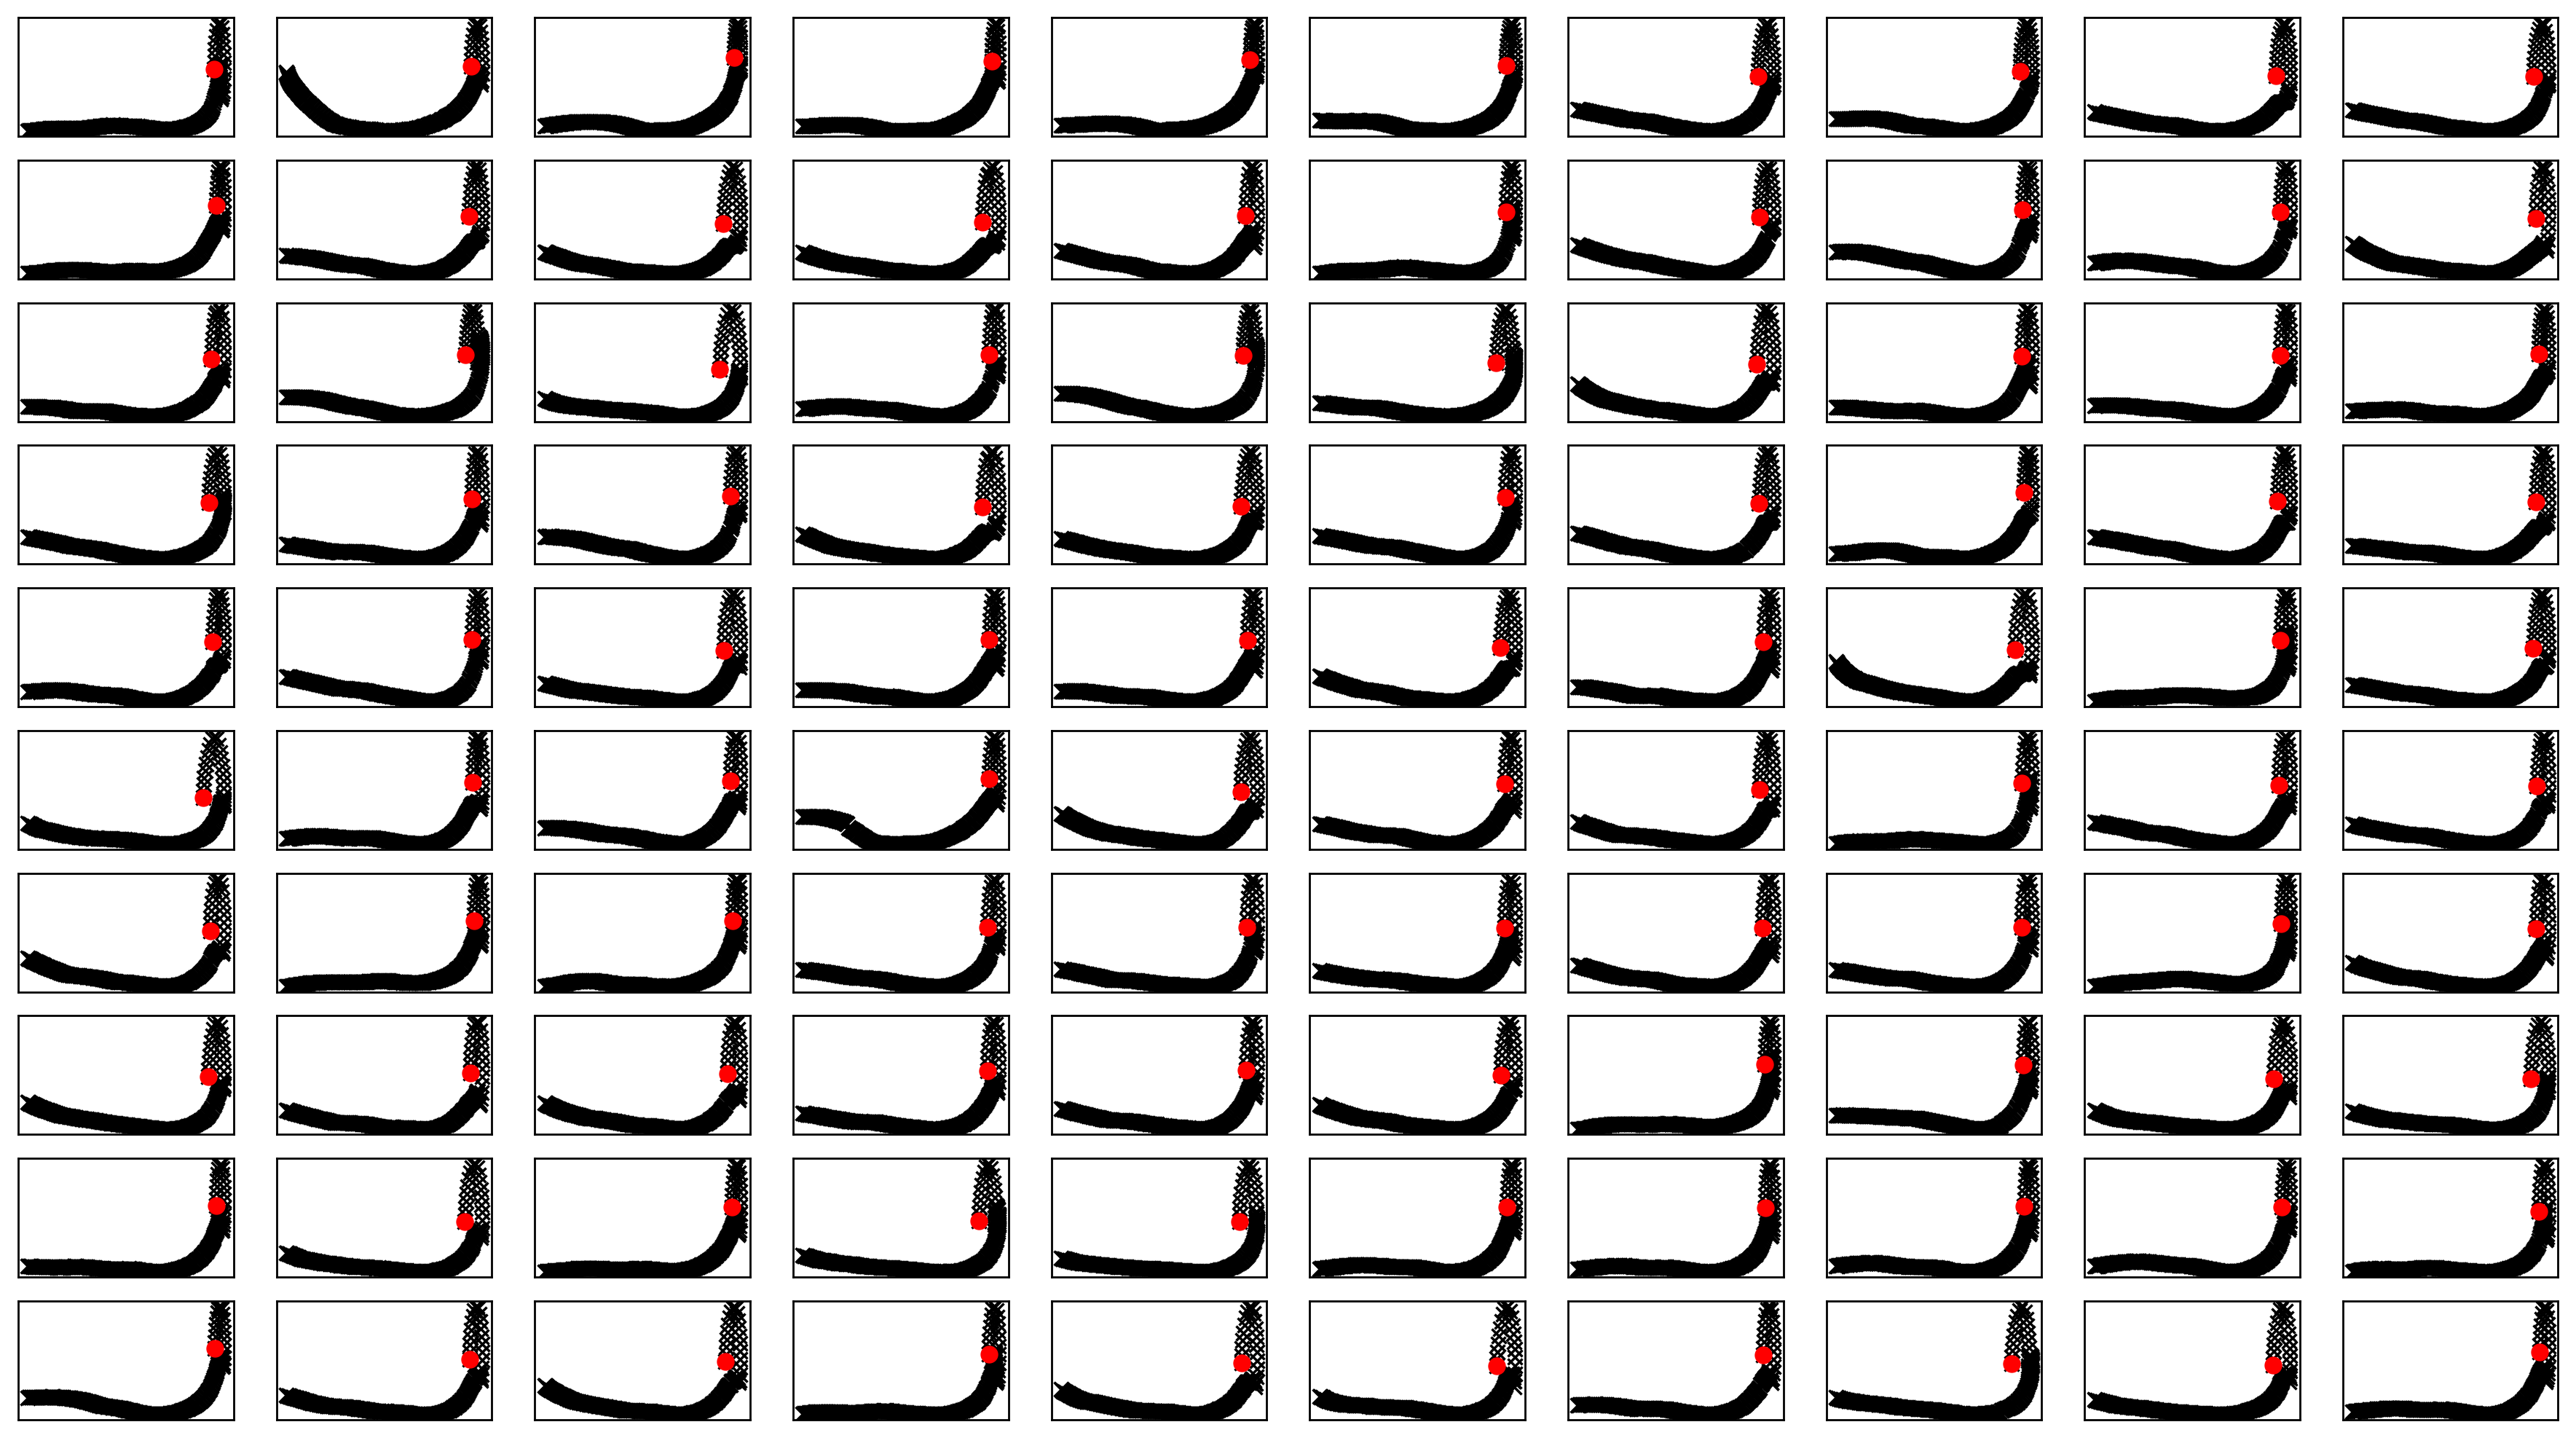

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

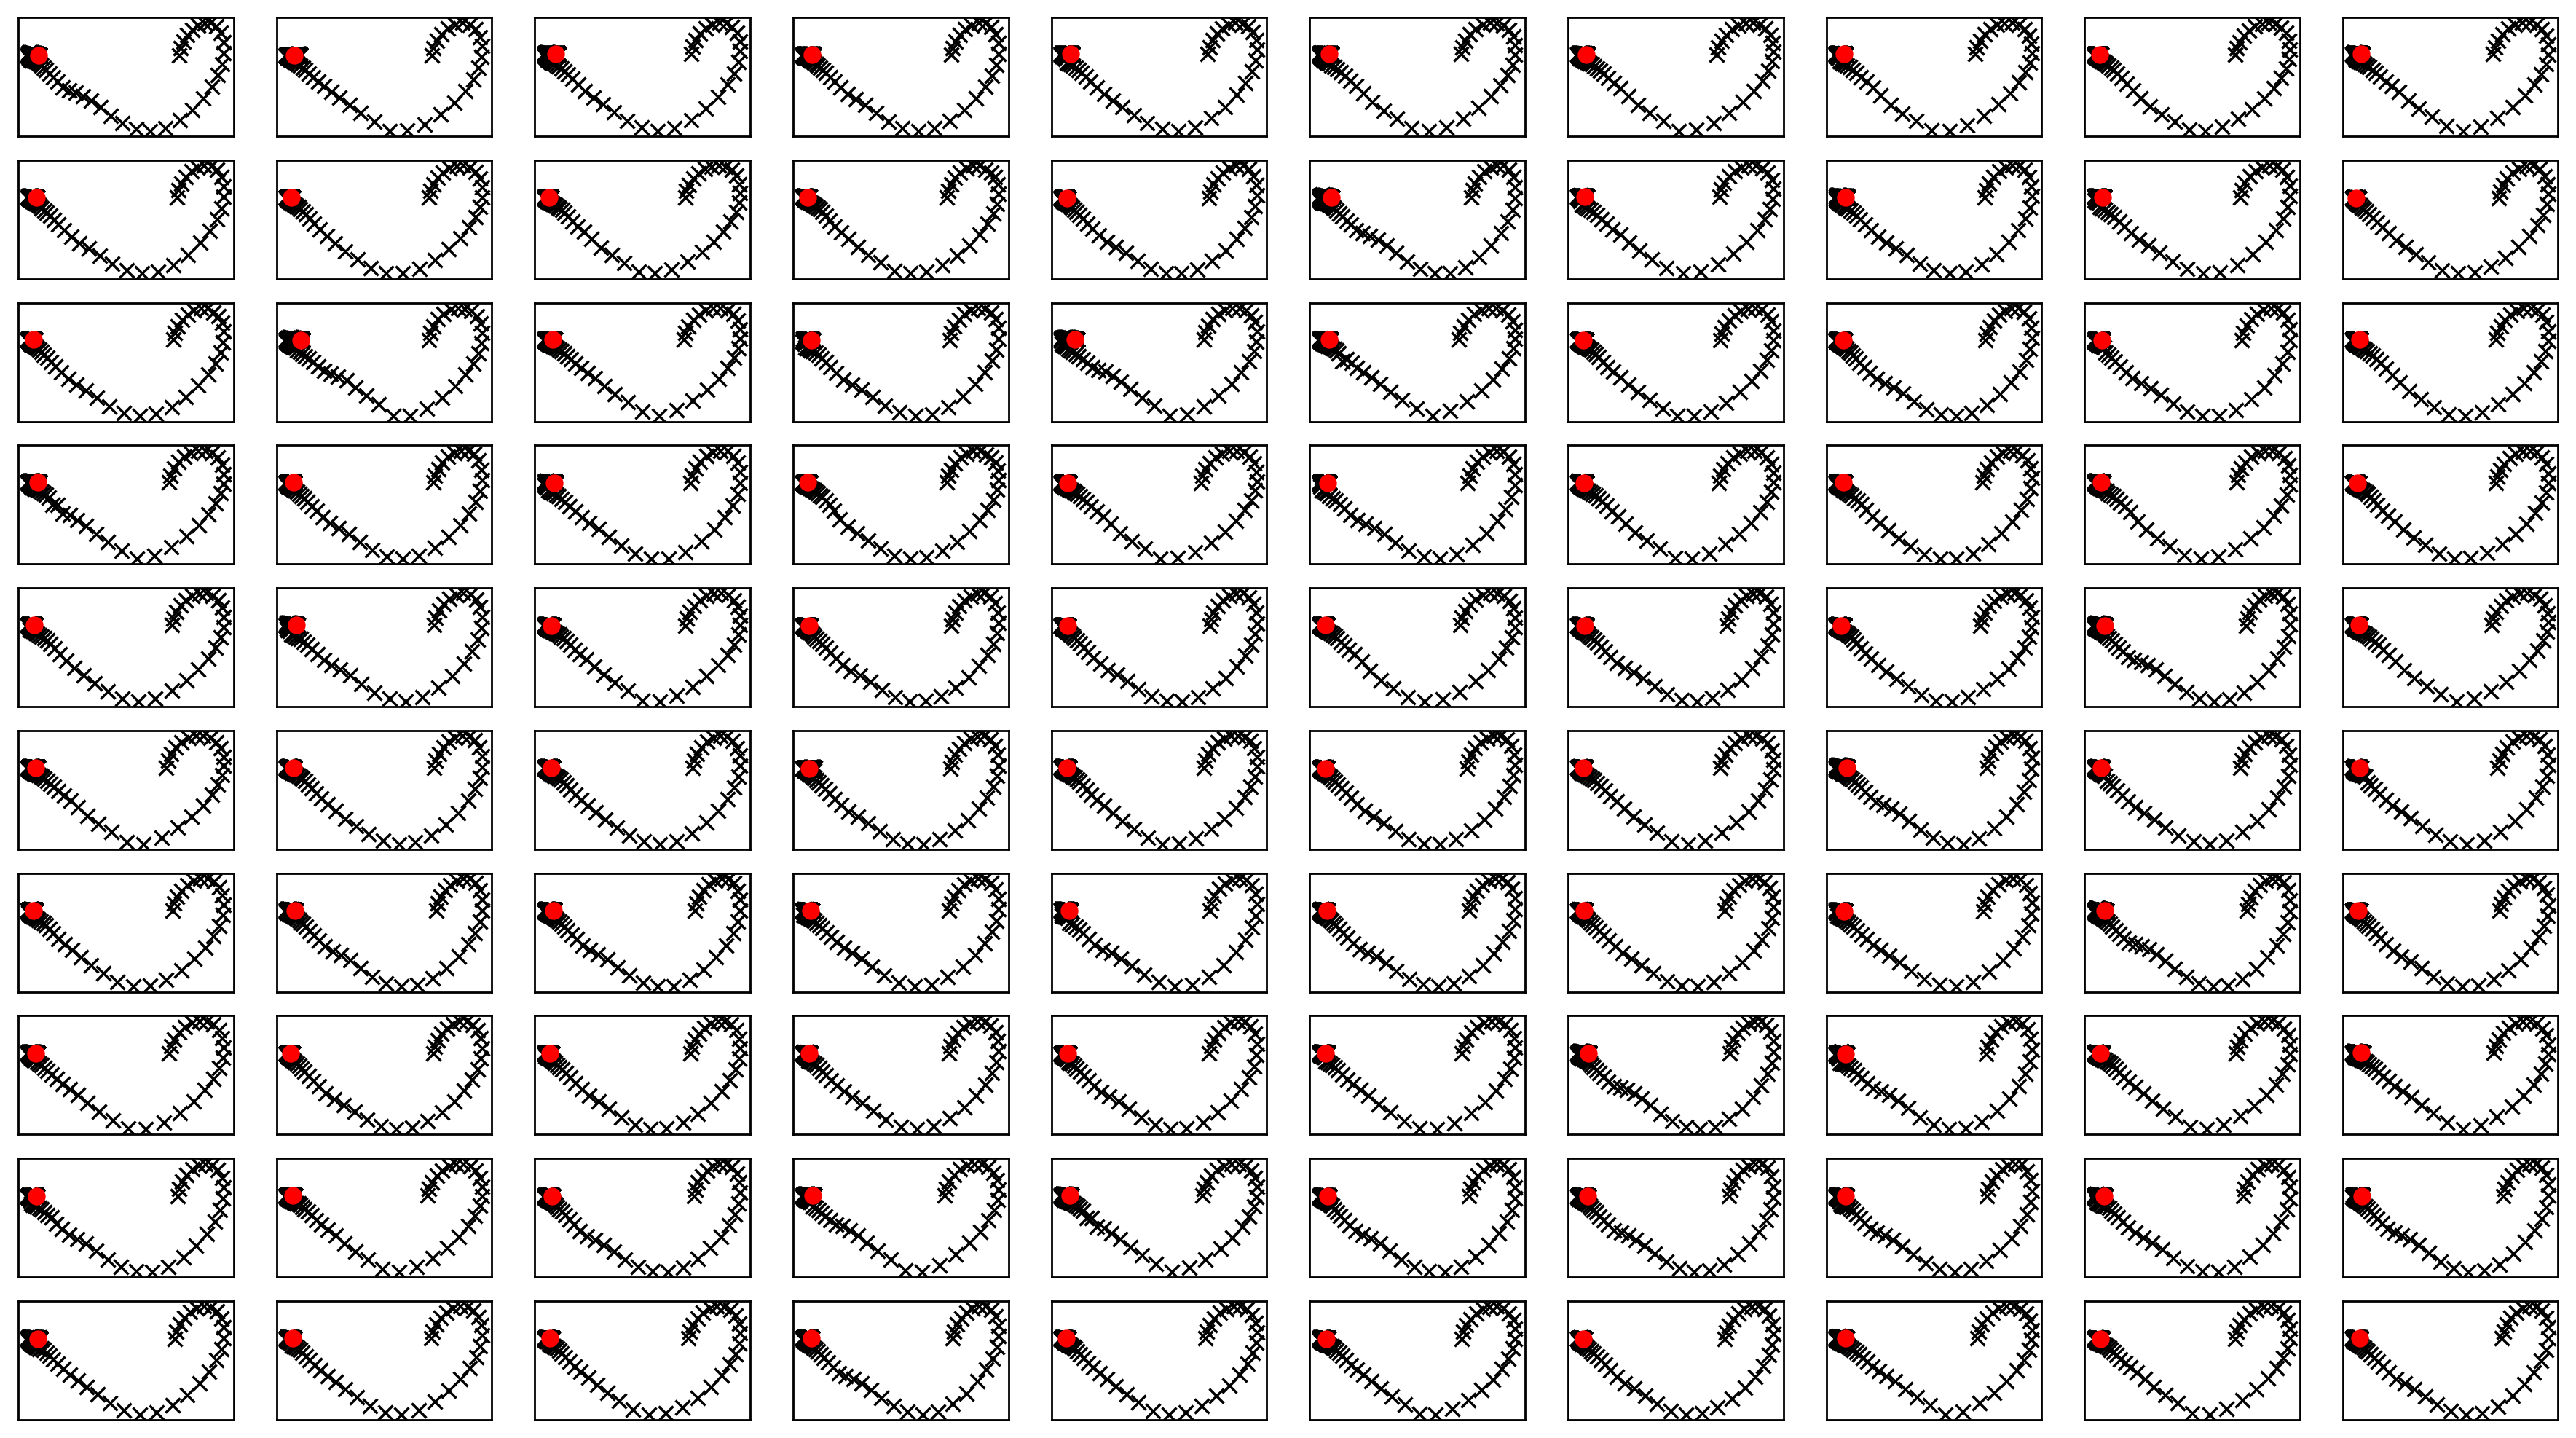

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-07-30 11:50:39.368561


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.34123  validloss 1.40560±0.00000  bestvalidloss 1.40560  last_update 0
train: iter 1  trainloss 1.21174  validloss 1.25196±0.00000  bestvalidloss 1.25196  last_update 0
train: iter 2  trainloss 1.09827  validloss 1.10090±0.00000  bestvalidloss 1.10090  last_update 0
train: iter 3  trainloss 1.01207  validloss 0.99824±0.00000  bestvalidloss 0.99824  last_update 0
train: iter 4  trainloss 0.95314  validloss 0.92325±0.00000  bestvalidloss 0.92325  last_update 0
train: iter 5  trainloss 0.91290  validloss 0.87868±0.00000  bestvalidloss 0.87868  last_update 0
train: iter 6  trainloss 0.86691  validloss 0.82064±0.00000  bestvalidloss 0.82064  last_update 0
train: iter 7  trainloss 0.82177  validloss 0.75772±0.00000  bestvalidloss 0.75772  last_update 0
train: iter 8  trainloss 0.78341  validloss 0.70621±0.00000  bestvalidloss 0.70621  last_update 0
train: iter 9  trainloss 0.74552  validloss 0.68623±0.00000  bestvalidloss 0.68623  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.37610  validloss 0.36769±0.00000  bestvalidloss 0.35839  last_update 1
train: iter 84  trainloss 0.37123  validloss 0.37297±0.00000  bestvalidloss 0.35839  last_update 2
train: iter 85  trainloss 0.36622  validloss 0.36431±0.00000  bestvalidloss 0.35839  last_update 3
train: iter 86  trainloss 0.36418  validloss 0.36051±0.00000  bestvalidloss 0.35839  last_update 4
train: iter 87  trainloss 0.36473  validloss 0.37331±0.00000  bestvalidloss 0.35839  last_update 5
train: iter 88  trainloss 0.36327  validloss 0.36299±0.00000  bestvalidloss 0.35839  last_update 6
train: iter 89  trainloss 0.36286  validloss 0.35559±0.00000  bestvalidloss 0.35559  last_update 0
train: iter 90  trainloss 0.36041  validloss 0.35565±0.00000  bestvalidloss 0.35559  last_update 1
train: iter 91  trainloss 0.36212  validloss 0.36233±0.00000  bestvalidloss 0.35559  last_update 2
train: iter 92  trainloss 0.36077  validloss 0.36912±0.00000  bestvalidloss 0.35559  last_update 3
train: ite

train: iter 166  trainloss 0.31614  validloss 0.32558±0.00000  bestvalidloss 0.31939  last_update 1
train: iter 167  trainloss 0.31724  validloss 0.33815±0.00000  bestvalidloss 0.31939  last_update 2
train: iter 168  trainloss 0.30816  validloss 0.33882±0.00000  bestvalidloss 0.31939  last_update 3
train: iter 169  trainloss 0.30957  validloss 0.32075±0.00000  bestvalidloss 0.31939  last_update 4
train: iter 170  trainloss 0.31319  validloss 0.32694±0.00000  bestvalidloss 0.31939  last_update 5
train: iter 171  trainloss 0.31081  validloss 0.32410±0.00000  bestvalidloss 0.31939  last_update 6
train: iter 172  trainloss 0.30932  validloss 0.31745±0.00000  bestvalidloss 0.31745  last_update 0
train: iter 173  trainloss 0.31659  validloss 0.34073±0.00000  bestvalidloss 0.31745  last_update 1
train: iter 174  trainloss 0.31586  validloss 0.33344±0.00000  bestvalidloss 0.31745  last_update 2
train: iter 175  trainloss 0.31269  validloss 0.32058±0.00000  bestvalidloss 0.31745  last_update 3


train: iter 248  trainloss 0.28770  validloss 0.31182±0.00000  bestvalidloss 0.30778  last_update 1
train: iter 249  trainloss 0.28372  validloss 0.32777±0.00000  bestvalidloss 0.30778  last_update 2
train: iter 250  trainloss 0.28709  validloss 0.30604±0.00000  bestvalidloss 0.30604  last_update 0
train: iter 251  trainloss 0.28334  validloss 0.31451±0.00000  bestvalidloss 0.30604  last_update 1
train: iter 252  trainloss 0.28466  validloss 0.30887±0.00000  bestvalidloss 0.30604  last_update 2
train: iter 253  trainloss 0.28543  validloss 0.30838±0.00000  bestvalidloss 0.30604  last_update 3
train: iter 254  trainloss 0.29103  validloss 0.31921±0.00000  bestvalidloss 0.30604  last_update 4
train: iter 255  trainloss 0.28600  validloss 0.30652±0.00000  bestvalidloss 0.30604  last_update 5
train: iter 256  trainloss 0.28480  validloss 0.31121±0.00000  bestvalidloss 0.30604  last_update 6
train: iter 257  trainloss 0.28493  validloss 0.31177±0.00000  bestvalidloss 0.30604  last_update 7


train: iter 330  trainloss 0.26868  validloss 0.29684±0.00000  bestvalidloss 0.29317  last_update 8
train: iter 331  trainloss 0.26820  validloss 0.31185±0.00000  bestvalidloss 0.29317  last_update 9
train: iter 332  trainloss 0.26837  validloss 0.29687±0.00000  bestvalidloss 0.29317  last_update 10
train: iter 333  trainloss 0.27404  validloss 0.31179±0.00000  bestvalidloss 0.29317  last_update 11
train: iter 334  trainloss 0.27055  validloss 0.30452±0.00000  bestvalidloss 0.29317  last_update 12
train: iter 335  trainloss 0.26896  validloss 0.29741±0.00000  bestvalidloss 0.29317  last_update 13
train: iter 336  trainloss 0.26848  validloss 0.29482±0.00000  bestvalidloss 0.29317  last_update 14
train: iter 337  trainloss 0.26653  validloss 0.29500±0.00000  bestvalidloss 0.29317  last_update 15
train: iter 338  trainloss 0.26465  validloss 0.29050±0.00000  bestvalidloss 0.29050  last_update 0
train: iter 339  trainloss 0.27209  validloss 0.29291±0.00000  bestvalidloss 0.29050  last_upd

train: iter 412  trainloss 0.26256  validloss 0.28887±0.00000  bestvalidloss 0.28035  last_update 5
train: iter 413  trainloss 0.25967  validloss 0.28013±0.00000  bestvalidloss 0.28013  last_update 0
train: iter 414  trainloss 0.25631  validloss 0.28167±0.00000  bestvalidloss 0.28013  last_update 1
train: iter 415  trainloss 0.25833  validloss 0.28761±0.00000  bestvalidloss 0.28013  last_update 2
train: iter 416  trainloss 0.25763  validloss 0.28695±0.00000  bestvalidloss 0.28013  last_update 3
train: iter 417  trainloss 0.25600  validloss 0.28170±0.00000  bestvalidloss 0.28013  last_update 4
train: iter 418  trainloss 0.26008  validloss 0.28471±0.00000  bestvalidloss 0.28013  last_update 5
train: iter 419  trainloss 0.26128  validloss 0.28709±0.00000  bestvalidloss 0.28013  last_update 6
train: iter 420  trainloss 0.25332  validloss 0.27859±0.00000  bestvalidloss 0.27859  last_update 0
train: iter 421  trainloss 0.25762  validloss 0.29356±0.00000  bestvalidloss 0.27859  last_update 1


train: iter 494  trainloss 0.24854  validloss 0.27133±0.00000  bestvalidloss 0.27133  last_update 0
train: iter 495  trainloss 0.24937  validloss 0.27715±0.00000  bestvalidloss 0.27133  last_update 1
train: iter 496  trainloss 0.24662  validloss 0.27075±0.00000  bestvalidloss 0.27075  last_update 0
train: iter 497  trainloss 0.24828  validloss 0.27404±0.00000  bestvalidloss 0.27075  last_update 1
train: iter 498  trainloss 0.24741  validloss 0.27652±0.00000  bestvalidloss 0.27075  last_update 2
train: iter 499  trainloss 0.24877  validloss 0.28038±0.00000  bestvalidloss 0.27075  last_update 3
train: iter 500  trainloss 0.24722  validloss 0.27083±0.00000  bestvalidloss 0.27075  last_update 4
train: iter 501  trainloss 0.24633  validloss 0.27015±0.00000  bestvalidloss 0.27015  last_update 0
train: iter 502  trainloss 0.24511  validloss 0.28668±0.00000  bestvalidloss 0.27015  last_update 1
train: iter 503  trainloss 0.25717  validloss 0.27698±0.00000  bestvalidloss 0.27015  last_update 2


train: iter 576  trainloss 0.23860  validloss 0.28475±0.00000  bestvalidloss 0.26439  last_update 25
train: iter 577  trainloss 0.23941  validloss 0.27218±0.00000  bestvalidloss 0.26439  last_update 26
train: iter 578  trainloss 0.24129  validloss 0.27277±0.00000  bestvalidloss 0.26439  last_update 27
train: iter 579  trainloss 0.23892  validloss 0.27833±0.00000  bestvalidloss 0.26439  last_update 28
train: iter 580  trainloss 0.24206  validloss 0.26823±0.00000  bestvalidloss 0.26439  last_update 29
train: iter 581  trainloss 0.24036  validloss 0.27770±0.00000  bestvalidloss 0.26439  last_update 30
train: iter 582  trainloss 0.24310  validloss 0.26807±0.00000  bestvalidloss 0.26439  last_update 31
train: iter 583  trainloss 0.23955  validloss 0.27768±0.00000  bestvalidloss 0.26439  last_update 32
train: iter 584  trainloss 0.24001  validloss 0.27455±0.00000  bestvalidloss 0.26439  last_update 33
train: iter 585  trainloss 0.23677  validloss 0.28066±0.00000  bestvalidloss 0.26439  last_

train: iter 658  trainloss 0.23261  validloss 0.27024±0.00000  bestvalidloss 0.25779  last_update 13
train: iter 659  trainloss 0.23367  validloss 0.26883±0.00000  bestvalidloss 0.25779  last_update 14
train: iter 660  trainloss 0.23098  validloss 0.26424±0.00000  bestvalidloss 0.25779  last_update 15
train: iter 661  trainloss 0.22976  validloss 0.26954±0.00000  bestvalidloss 0.25779  last_update 16
train: iter 662  trainloss 0.23036  validloss 0.27492±0.00000  bestvalidloss 0.25779  last_update 17
train: iter 663  trainloss 0.22980  validloss 0.26361±0.00000  bestvalidloss 0.25779  last_update 18
train: iter 664  trainloss 0.23383  validloss 0.27732±0.00000  bestvalidloss 0.25779  last_update 19
train: iter 665  trainloss 0.23129  validloss 0.26798±0.00000  bestvalidloss 0.25779  last_update 20
train: iter 666  trainloss 0.23014  validloss 0.26330±0.00000  bestvalidloss 0.25779  last_update 21
train: iter 667  trainloss 0.22856  validloss 0.26094±0.00000  bestvalidloss 0.25779  last_

train: iter 740  trainloss 0.22221  validloss 0.26159±0.00000  bestvalidloss 0.25285  last_update 9
train: iter 741  trainloss 0.22163  validloss 0.26953±0.00000  bestvalidloss 0.25285  last_update 10
train: iter 742  trainloss 0.21832  validloss 0.26441±0.00000  bestvalidloss 0.25285  last_update 11
train: iter 743  trainloss 0.22418  validloss 0.26628±0.00000  bestvalidloss 0.25285  last_update 12
train: iter 744  trainloss 0.22325  validloss 0.26574±0.00000  bestvalidloss 0.25285  last_update 13
train: iter 745  trainloss 0.22244  validloss 0.25688±0.00000  bestvalidloss 0.25285  last_update 14
train: iter 746  trainloss 0.22432  validloss 0.25888±0.00000  bestvalidloss 0.25285  last_update 15
train: iter 747  trainloss 0.22216  validloss 0.25525±0.00000  bestvalidloss 0.25285  last_update 16
train: iter 748  trainloss 0.22083  validloss 0.25526±0.00000  bestvalidloss 0.25285  last_update 17
train: iter 749  trainloss 0.22244  validloss 0.26272±0.00000  bestvalidloss 0.25285  last_u

train: iter 822  trainloss 0.21670  validloss 0.27276±0.00000  bestvalidloss 0.25081  last_update 60
train: iter 823  trainloss 0.21282  validloss 0.25169±0.00000  bestvalidloss 0.25081  last_update 61
train: iter 824  trainloss 0.21506  validloss 0.29614±0.00000  bestvalidloss 0.25081  last_update 62
train: iter 825  trainloss 0.21691  validloss 0.26365±0.00000  bestvalidloss 0.25081  last_update 63
train: iter 826  trainloss 0.21406  validloss 0.25806±0.00000  bestvalidloss 0.25081  last_update 64
train: iter 827  trainloss 0.21379  validloss 0.25943±0.00000  bestvalidloss 0.25081  last_update 65
train: iter 828  trainloss 0.21611  validloss 0.26116±0.00000  bestvalidloss 0.25081  last_update 66
train: iter 829  trainloss 0.21259  validloss 0.25876±0.00000  bestvalidloss 0.25081  last_update 67
train: iter 830  trainloss 0.21789  validloss 0.26435±0.00000  bestvalidloss 0.25081  last_update 68
train: iter 831  trainloss 0.21562  validloss 0.27730±0.00000  bestvalidloss 0.25081  last_

train: iter 904  trainloss 0.21005  validloss 0.26034±0.00000  bestvalidloss 0.24837  last_update 44
train: iter 905  trainloss 0.21098  validloss 0.25513±0.00000  bestvalidloss 0.24837  last_update 45
train: iter 906  trainloss 0.20798  validloss 0.26097±0.00000  bestvalidloss 0.24837  last_update 46
train: iter 907  trainloss 0.20728  validloss 0.25179±0.00000  bestvalidloss 0.24837  last_update 47
train: iter 908  trainloss 0.20886  validloss 0.26371±0.00000  bestvalidloss 0.24837  last_update 48
train: iter 909  trainloss 0.20863  validloss 0.26340±0.00000  bestvalidloss 0.24837  last_update 49
train: iter 910  trainloss 0.20778  validloss 0.25925±0.00000  bestvalidloss 0.24837  last_update 50
train: iter 911  trainloss 0.20806  validloss 0.25809±0.00000  bestvalidloss 0.24837  last_update 51
train: iter 912  trainloss 0.21069  validloss 0.27985±0.00000  bestvalidloss 0.24837  last_update 52
train: iter 913  trainloss 0.20723  validloss 0.26776±0.00000  bestvalidloss 0.24837  last_

train: iter 986  trainloss 0.20341  validloss 0.25530±0.00000  bestvalidloss 0.24787  last_update 44
train: iter 987  trainloss 0.20642  validloss 0.25485±0.00000  bestvalidloss 0.24787  last_update 45
train: iter 988  trainloss 0.20210  validloss 0.27464±0.00000  bestvalidloss 0.24787  last_update 46
train: iter 989  trainloss 0.20173  validloss 0.25422±0.00000  bestvalidloss 0.24787  last_update 47
train: iter 990  trainloss 0.20514  validloss 0.27733±0.00000  bestvalidloss 0.24787  last_update 48
train: iter 991  trainloss 0.20475  validloss 0.26078±0.00000  bestvalidloss 0.24787  last_update 49
train: iter 992  trainloss 0.20563  validloss 0.26845±0.00000  bestvalidloss 0.24787  last_update 50
train: iter 993  trainloss 0.20134  validloss 0.27126±0.00000  bestvalidloss 0.24787  last_update 51
train: iter 994  trainloss 0.20525  validloss 0.26657±0.00000  bestvalidloss 0.24787  last_update 52
train: iter 995  trainloss 0.20589  validloss 0.26977±0.00000  bestvalidloss 0.24787  last_

train_loss:  -2.649339643880725
valid_loss:  -2.851944174027443
weight_alpha 1.0 h_min_tilde -11.833602 ell_tilde -2.689860549910069 kappa_tilde 0.0003307029221692772
train_loss:  -3.2177292888641347
valid_loss:  -2.817872723388672
weight_alpha 0.1 h_min_tilde -11.833602 ell_tilde -3.137757975769042 kappa_tilde 0.0003391127592344412


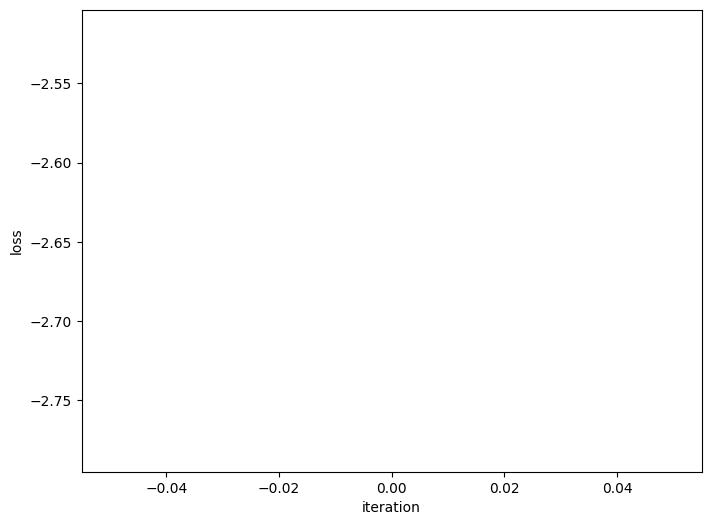

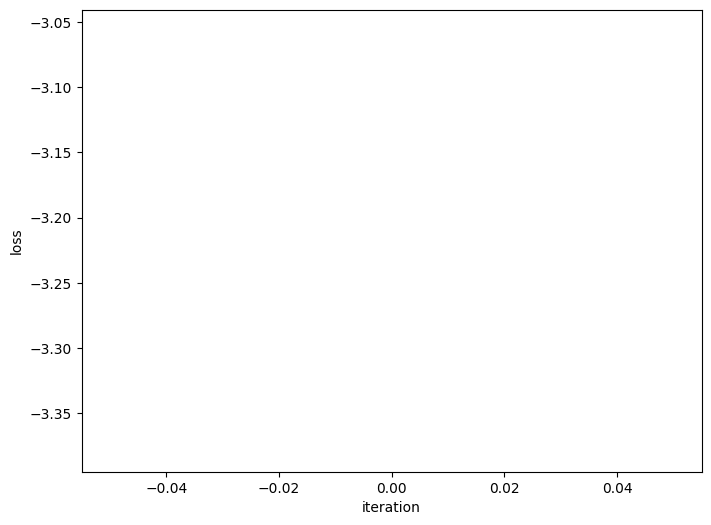

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -630.47838  validloss -565.92160±0.00000  bestvalidloss -565.92160  last_update 0
train: iter 1  trainloss -616.89218  validloss -553.03694±0.00000  bestvalidloss -565.92160  last_update 1
train: iter 2  trainloss -627.87678  validloss -458.23103±0.00000  bestvalidloss -565.92160  last_update 2
train: iter 3  trainloss -645.70658  validloss -571.34965±0.00000  bestvalidloss -571.34965  last_update 0
train: iter 4  trainloss -644.30032  validloss -571.78103±0.00000  bestvalidloss -571.78103  last_update 0
train: iter 5  trainloss -643.80272  validloss -556.90522±0.00000  bestvalidloss -571.78103  last_update 1
train: iter 6  trainloss -639.34916  validloss -568.21091±0.00000  bestvalidloss -571.78103  last_update 2
train: iter 7  trainloss -641.59795  validloss -560.49763±0.00000  bestvalidloss -571.78103  last_update 3
train: iter 8  trainloss -648.59278  validloss -558.83373±0.00000  bestvalidloss -571.78103  last_u

train: iter 76  trainloss -660.31526  validloss -554.53098±0.00000  bestvalidloss -577.81653  last_update 2
train: iter 77  trainloss -668.46956  validloss -564.88905±0.00000  bestvalidloss -577.81653  last_update 3
train: iter 78  trainloss -666.41609  validloss -581.63759±0.00000  bestvalidloss -581.63759  last_update 0
train: iter 79  trainloss -667.44950  validloss -584.89767±0.00000  bestvalidloss -584.89767  last_update 0
train: iter 80  trainloss -656.69081  validloss -567.77714±0.00000  bestvalidloss -584.89767  last_update 1
train: iter 81  trainloss -656.59712  validloss -549.90450±0.00000  bestvalidloss -584.89767  last_update 2
train: iter 82  trainloss -642.19326  validloss -573.47933±0.00000  bestvalidloss -584.89767  last_update 3
train: iter 83  trainloss -639.04845  validloss -532.79852±0.00000  bestvalidloss -584.89767  last_update 4
train: iter 84  trainloss -653.88669  validloss -510.16579±0.00000  bestvalidloss -584.89767  last_update 5
train: iter 85  trainloss -6

train: iter 152  trainloss -692.01280  validloss -573.83488±0.00000  bestvalidloss -593.60526  last_update 3
train: iter 153  trainloss -700.80619  validloss -591.05947±0.00000  bestvalidloss -593.60526  last_update 4
train: iter 154  trainloss -679.68421  validloss -592.66780±0.00000  bestvalidloss -593.60526  last_update 5
train: iter 155  trainloss -672.74125  validloss -582.46557±0.00000  bestvalidloss -593.60526  last_update 6
train: iter 156  trainloss -683.52765  validloss -574.79194±0.00000  bestvalidloss -593.60526  last_update 7
train: iter 157  trainloss -686.29739  validloss -560.97258±0.00000  bestvalidloss -593.60526  last_update 8
train: iter 158  trainloss -695.95296  validloss -526.24237±0.00000  bestvalidloss -593.60526  last_update 9
train: iter 159  trainloss -687.02547  validloss -581.36199±0.00000  bestvalidloss -593.60526  last_update 10
train: iter 160  trainloss -653.89414  validloss -582.27361±0.00000  bestvalidloss -593.60526  last_update 11
train: iter 161  

train: iter 227  trainloss -720.14129  validloss -575.56850±0.00000  bestvalidloss -606.55336  last_update 6
train: iter 228  trainloss -720.77547  validloss -584.64352±0.00000  bestvalidloss -606.55336  last_update 7
train: iter 229  trainloss -713.79273  validloss -601.87494±0.00000  bestvalidloss -606.55336  last_update 8
train: iter 230  trainloss -726.01165  validloss -601.83615±0.00000  bestvalidloss -606.55336  last_update 9
train: iter 231  trainloss -719.81648  validloss -589.54502±0.00000  bestvalidloss -606.55336  last_update 10
train: iter 232  trainloss -718.59110  validloss -593.13895±0.00000  bestvalidloss -606.55336  last_update 11
train: iter 233  trainloss -722.49816  validloss -598.60167±0.00000  bestvalidloss -606.55336  last_update 12
train: iter 234  trainloss -703.99633  validloss -602.10415±0.00000  bestvalidloss -606.55336  last_update 13
train: iter 235  trainloss -722.01887  validloss -595.42591±0.00000  bestvalidloss -606.55336  last_update 14
train: iter 23

train: iter 302  trainloss -736.26840  validloss -614.81568±0.00000  bestvalidloss -625.76092  last_update 29
train: iter 303  trainloss -746.21977  validloss -628.81219±0.00000  bestvalidloss -628.81219  last_update 0
train: iter 304  trainloss -733.00729  validloss -614.19391±0.00000  bestvalidloss -628.81219  last_update 1
train: iter 305  trainloss -617.32580  validloss -620.94436±0.00000  bestvalidloss -628.81219  last_update 2
train: iter 306  trainloss -599.52033  validloss -389.42000±0.00000  bestvalidloss -628.81219  last_update 3
train: iter 307  trainloss -650.68773  validloss -512.04603±0.00000  bestvalidloss -628.81219  last_update 4
train: iter 308  trainloss -685.22978  validloss -538.57022±0.00000  bestvalidloss -628.81219  last_update 5
train: iter 309  trainloss -663.80117  validloss -543.59640±0.00000  bestvalidloss -628.81219  last_update 6
train: iter 310  trainloss -698.12679  validloss -565.30279±0.00000  bestvalidloss -628.81219  last_update 7
train: iter 311  t

train: iter 377  trainloss -745.18156  validloss -607.80885±0.00000  bestvalidloss -642.43279  last_update 13
train: iter 378  trainloss -759.43582  validloss -621.88254±0.00000  bestvalidloss -642.43279  last_update 14
train: iter 379  trainloss -765.25816  validloss -620.46312±0.00000  bestvalidloss -642.43279  last_update 15
train: iter 380  trainloss -766.13449  validloss -616.13218±0.00000  bestvalidloss -642.43279  last_update 16
train: iter 381  trainloss -757.14876  validloss -624.14631±0.00000  bestvalidloss -642.43279  last_update 17
train: iter 382  trainloss -760.00565  validloss -636.62141±0.00000  bestvalidloss -642.43279  last_update 18
train: iter 383  trainloss -750.64065  validloss -608.51732±0.00000  bestvalidloss -642.43279  last_update 19
train: iter 384  trainloss -727.11313  validloss -624.71086±0.00000  bestvalidloss -642.43279  last_update 20
train: iter 385  trainloss -759.74874  validloss -613.09585±0.00000  bestvalidloss -642.43279  last_update 21
train: ite

train: iter 452  trainloss -746.32628  validloss -601.95274±0.00000  bestvalidloss -642.43279  last_update 88
train: iter 453  trainloss -765.94270  validloss -602.26320±0.00000  bestvalidloss -642.43279  last_update 89
train: iter 454  trainloss -771.66200  validloss -612.14703±0.00000  bestvalidloss -642.43279  last_update 90
train: iter 455  trainloss -775.05188  validloss -632.15198±0.00000  bestvalidloss -642.43279  last_update 91
train: iter 456  trainloss -766.10037  validloss -601.91774±0.00000  bestvalidloss -642.43279  last_update 92
train: iter 457  trainloss -772.78699  validloss -624.09443±0.00000  bestvalidloss -642.43279  last_update 93
train: iter 458  trainloss -747.49184  validloss -603.21982±0.00000  bestvalidloss -642.43279  last_update 94
train: iter 459  trainloss -759.69947  validloss -608.10948±0.00000  bestvalidloss -642.43279  last_update 95
train: iter 460  trainloss -765.75202  validloss -625.40749±0.00000  bestvalidloss -642.43279  last_update 96
train: ite

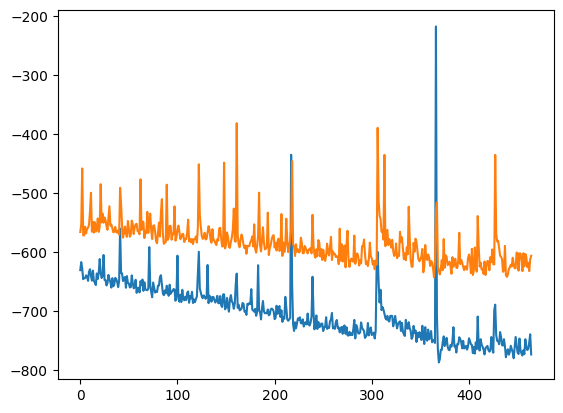

alpha 0.1 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-07-30 12:22:59.602859


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.49615  validloss 2.97192±0.00000  bestvalidloss 2.97192  last_update 0
train: iter 1  trainloss 0.64059  validloss 0.98865±0.00000  bestvalidloss 0.98865  last_update 0
train: iter 2  trainloss 0.50388  validloss 0.55502±0.00000  bestvalidloss 0.55502  last_update 0
train: iter 3  trainloss 0.47667  validloss 0.53193±0.00000  bestvalidloss 0.53193  last_update 0
train: iter 4  trainloss 0.45421  validloss 0.51647±0.00000  bestvalidloss 0.51647  last_update 0
train: iter 5  trainloss 0.44632  validloss 0.45494±0.00000  bestvalidloss 0.45494  last_update 0
train: iter 6  trainloss 0.43404  validloss 0.45137±0.00000  bestvalidloss 0.45137  last_update 0
train: iter 7  trainloss 0.42500  validloss 0.43437±0.00000  bestvalidloss 0.43437  last_update 0
train: iter 8  trainloss 0.41830  validloss 0.44368±0.00000  bestvalidloss 0.43437  last_update 1
train: iter 9  trainloss 0.41230  validloss 0.41794±0.00000  bestvalidloss 0.41794  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.30371  validloss 0.34203±0.00000  bestvalidloss 0.33082  last_update 8
train: iter 84  trainloss 0.30213  validloss 0.37311±0.00000  bestvalidloss 0.33082  last_update 9
train: iter 85  trainloss 0.30111  validloss 0.34167±0.00000  bestvalidloss 0.33082  last_update 10
train: iter 86  trainloss 0.30216  validloss 0.35803±0.00000  bestvalidloss 0.33082  last_update 11
train: iter 87  trainloss 0.30194  validloss 0.36708±0.00000  bestvalidloss 0.33082  last_update 12
train: iter 88  trainloss 0.30425  validloss 0.35966±0.00000  bestvalidloss 0.33082  last_update 13
train: iter 89  trainloss 0.30302  validloss 0.33738±0.00000  bestvalidloss 0.33082  last_update 14
train: iter 90  trainloss 0.30070  validloss 0.36857±0.00000  bestvalidloss 0.33082  last_update 15
train: iter 91  trainloss 0.30418  validloss 0.34677±0.00000  bestvalidloss 0.33082  last_update 16
train: iter 92  trainloss 0.30313  validloss 0.36446±0.00000  bestvalidloss 0.33082  last_update 17
tr

train: iter 166  trainloss 0.28798  validloss 0.35436±0.00000  bestvalidloss 0.32378  last_update 41
train: iter 167  trainloss 0.28414  validloss 0.34785±0.00000  bestvalidloss 0.32378  last_update 42
train: iter 168  trainloss 0.28224  validloss 0.35274±0.00000  bestvalidloss 0.32378  last_update 43
train: iter 169  trainloss 0.28886  validloss 0.37104±0.00000  bestvalidloss 0.32378  last_update 44
train: iter 170  trainloss 0.28328  validloss 0.38540±0.00000  bestvalidloss 0.32378  last_update 45
train: iter 171  trainloss 0.28286  validloss 0.33907±0.00000  bestvalidloss 0.32378  last_update 46
train: iter 172  trainloss 0.28487  validloss 0.36813±0.00000  bestvalidloss 0.32378  last_update 47
train: iter 173  trainloss 0.28324  validloss 0.32834±0.00000  bestvalidloss 0.32378  last_update 48
train: iter 174  trainloss 0.28696  validloss 0.33263±0.00000  bestvalidloss 0.32378  last_update 49
train: iter 175  trainloss 0.28122  validloss 0.34671±0.00000  bestvalidloss 0.32378  last_

train: iter 248  trainloss 0.27778  validloss 0.34451±0.00000  bestvalidloss 0.31885  last_update 9
train: iter 249  trainloss 0.27302  validloss 0.33516±0.00000  bestvalidloss 0.31885  last_update 10
train: iter 250  trainloss 0.27478  validloss 0.37333±0.00000  bestvalidloss 0.31885  last_update 11
train: iter 251  trainloss 0.27220  validloss 0.33167±0.00000  bestvalidloss 0.31885  last_update 12
train: iter 252  trainloss 0.27533  validloss 0.36822±0.00000  bestvalidloss 0.31885  last_update 13
train: iter 253  trainloss 0.27182  validloss 0.33907±0.00000  bestvalidloss 0.31885  last_update 14
train: iter 254  trainloss 0.27432  validloss 0.36378±0.00000  bestvalidloss 0.31885  last_update 15
train: iter 255  trainloss 0.27156  validloss 0.34959±0.00000  bestvalidloss 0.31885  last_update 16
train: iter 256  trainloss 0.27379  validloss 0.35587±0.00000  bestvalidloss 0.31885  last_update 17
train: iter 257  trainloss 0.27384  validloss 0.32679±0.00000  bestvalidloss 0.31885  last_u

train: iter 330  trainloss 0.26603  validloss 0.34489±0.00000  bestvalidloss 0.31885  last_update 91
train: iter 331  trainloss 0.26644  validloss 0.36871±0.00000  bestvalidloss 0.31885  last_update 92
train: iter 332  trainloss 0.26663  validloss 0.34357±0.00000  bestvalidloss 0.31885  last_update 93
train: iter 333  trainloss 0.26427  validloss 0.37057±0.00000  bestvalidloss 0.31885  last_update 94
train: iter 334  trainloss 0.26477  validloss 0.36904±0.00000  bestvalidloss 0.31885  last_update 95
train: iter 335  trainloss 0.26723  validloss 0.37534±0.00000  bestvalidloss 0.31885  last_update 96
train: iter 336  trainloss 0.26557  validloss 0.36409±0.00000  bestvalidloss 0.31885  last_update 97
train: iter 337  trainloss 0.26698  validloss 0.38115±0.00000  bestvalidloss 0.31885  last_update 98
train: iter 338  trainloss 0.26058  validloss 0.35568±0.00000  bestvalidloss 0.31885  last_update 99
train: iter 339  trainloss 0.26654  validloss 0.39485±0.00000  bestvalidloss 0.31885  last_

train_loss:  -4.811245060783625
valid_loss:  -4.807076799631118
weight_alpha 1.0 h_min_tilde -12.055237 ell_tilde -4.810411408553124 kappa_tilde 0.0003715232849493882
train_loss:  -3.8196114294052124
valid_loss:  -3.3415489284515374
weight_alpha 0.1 h_min_tilde -12.055237 ell_tilde -3.7239989292144777 kappa_tilde 0.0003464537227593504


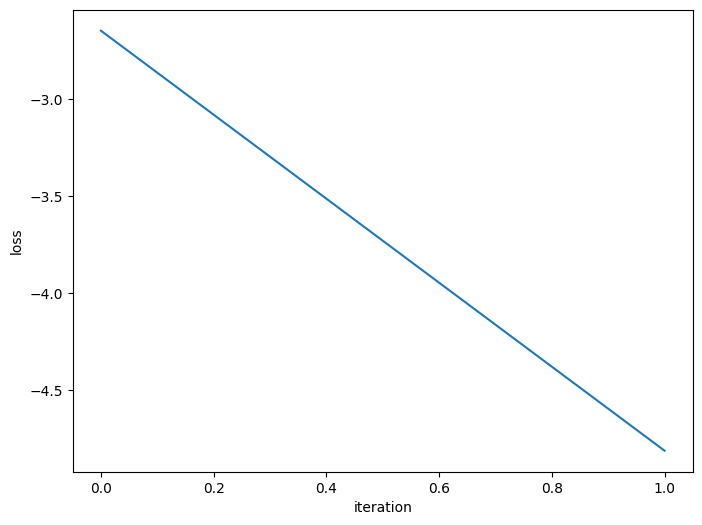

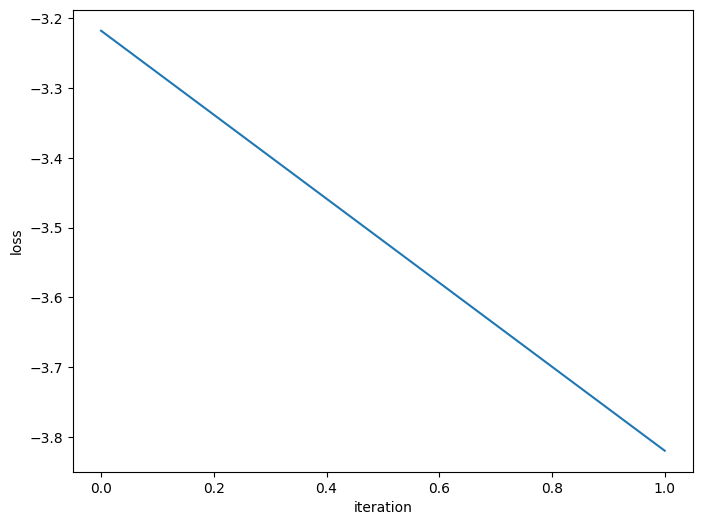

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -743.73950  validloss -670.14118±0.00000  bestvalidloss -670.14118  last_update 0
train: iter 1  trainloss -732.09982  validloss -576.01599±0.00000  bestvalidloss -670.14118  last_update 1
train: iter 2  trainloss -744.61615  validloss -611.64683±0.00000  bestvalidloss -670.14118  last_update 2
train: iter 3  trainloss -751.87329  validloss -674.50674±0.00000  bestvalidloss -674.50674  last_update 0
train: iter 4  trainloss -754.17587  validloss -670.31349±0.00000  bestvalidloss -674.50674  last_update 1
train: iter 5  trainloss -745.73586  validloss -643.96497±0.00000  bestvalidloss -674.50674  last_update 2
train: iter 6  trainloss -750.70084  validloss -645.04709±0.00000  bestvalidloss -674.50674  last_update 3
train: iter 7  trainloss -732.35505  validloss -656.44591±0.00000  bestvalidloss -674.50674  last_update 4
train: iter 8  trainloss -739.05160  validloss -616.11060±0.00000  bestvalidloss -674.50674  last_u

train: iter 76  trainloss -754.84744  validloss -628.18911±0.00000  bestvalidloss -688.03754  last_update 45
train: iter 77  trainloss -727.68501  validloss -667.86444±0.00000  bestvalidloss -688.03754  last_update 46
train: iter 78  trainloss -755.77910  validloss -673.29875±0.00000  bestvalidloss -688.03754  last_update 47
train: iter 79  trainloss -755.60567  validloss -644.21043±0.00000  bestvalidloss -688.03754  last_update 48
train: iter 80  trainloss -720.77636  validloss -147.29477±0.00000  bestvalidloss -688.03754  last_update 49
train: iter 81  trainloss -760.62054  validloss -635.84030±0.00000  bestvalidloss -688.03754  last_update 50
train: iter 82  trainloss -768.85803  validloss -646.86927±0.00000  bestvalidloss -688.03754  last_update 51
train: iter 83  trainloss -751.81635  validloss -665.18225±0.00000  bestvalidloss -688.03754  last_update 52
train: iter 84  trainloss -757.99722  validloss -671.48028±0.00000  bestvalidloss -688.03754  last_update 53
train: iter 85  tra

train: iter 151  trainloss -770.36297  validloss -675.28723±0.00000  bestvalidloss -704.52050  last_update 18
train: iter 152  trainloss -690.28539  validloss -623.11782±0.00000  bestvalidloss -704.52050  last_update 19
train: iter 153  trainloss -765.04309  validloss -622.96252±0.00000  bestvalidloss -704.52050  last_update 20
train: iter 154  trainloss -763.57813  validloss -675.30578±0.00000  bestvalidloss -704.52050  last_update 21
train: iter 155  trainloss -769.42257  validloss -659.24506±0.00000  bestvalidloss -704.52050  last_update 22
train: iter 156  trainloss -769.64860  validloss -673.80207±0.00000  bestvalidloss -704.52050  last_update 23
train: iter 157  trainloss -751.34452  validloss -628.29951±0.00000  bestvalidloss -704.52050  last_update 24
train: iter 158  trainloss -768.42487  validloss -683.70169±0.00000  bestvalidloss -704.52050  last_update 25
train: iter 159  trainloss -770.30931  validloss -653.55289±0.00000  bestvalidloss -704.52050  last_update 26
train: ite

train: iter 226  trainloss -777.73038  validloss -652.42266±0.00000  bestvalidloss -704.52050  last_update 93
train: iter 227  trainloss -784.33274  validloss -691.31157±0.00000  bestvalidloss -704.52050  last_update 94
train: iter 228  trainloss -773.65924  validloss -677.92771±0.00000  bestvalidloss -704.52050  last_update 95
train: iter 229  trainloss -743.51434  validloss -648.42676±0.00000  bestvalidloss -704.52050  last_update 96
train: iter 230  trainloss -761.58593  validloss -595.48847±0.00000  bestvalidloss -704.52050  last_update 97
train: iter 231  trainloss -775.16570  validloss -633.00880±0.00000  bestvalidloss -704.52050  last_update 98
train: iter 232  trainloss -781.02837  validloss -677.66885±0.00000  bestvalidloss -704.52050  last_update 99
train: iter 233  trainloss -779.98467  validloss -686.29247±0.00000  bestvalidloss -704.52050  last_update 100
train: fin
penalty_target_min tensor(-12.1312) penalty_target_max tensor(55.8315)


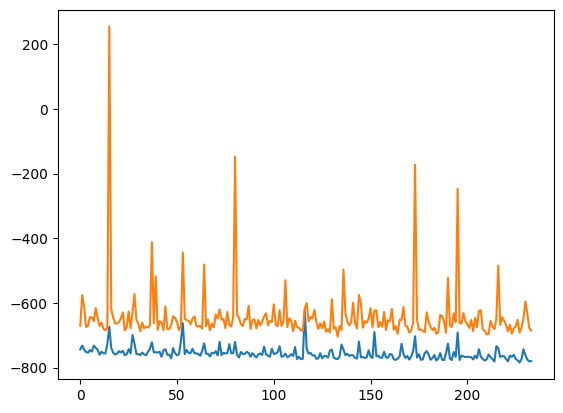

alpha 0.1 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-07-30 12:49:15.258134


In [25]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [26]:
policy_evaluation_iter=2

In [27]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11
predict diverge [-14.39498314   5.14517708 -50.99174241 -31.94186487] [ 0.29069722 -2.01552449 -1.75914286 -4.14854504] [139.468     23.342175 153.2716    28.861576] [69.734    11.671087 76.6358   14.430788] sim_timestep 175

 12

 13

 14

 15

 16
predict diverge [-12.32947141  30.29217283 -44.13759944 -28.0352877 ] [ 7.94335577e-01  1.28008548e+01 -1.74460851e+00 -9.73107662e-04] [139.468     23.342175 153.2716    28.861576] [69.734    11.671087 76.6358   14.430788] sim_timestep 187

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57
predict diverge [-10.52464452   6.24749139 -44.97435373 -31.80821404] [ 0.09966297  2.90901095 -1.56432777 -4.14889882] [139.468     23.342175 153.2716    28.861576] [69.734    11.671087 76.6358   14.430788] sim_timestep 194

 58

 59
predict diverge [ -

In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.48118  validloss 0.46820±0.00000  bestvalidloss 0.46820  last_update 0
train: iter 1  trainloss 0.41745  validloss 0.44698±0.00000  bestvalidloss 0.44698  last_update 0
train: iter 2  trainloss 0.39189  validloss 0.42808±0.00000  bestvalidloss 0.42808  last_update 0
train: iter 3  trainloss 0.38466  validloss 0.41828±0.00000  bestvalidloss 0.41828  last_update 0
train: iter 4  trainloss 0.36982  validloss 0.43164±0.00000  bestvalidloss 0.41828  last_update 1
train: iter 5  trainloss 0.36856  validloss 0.40177±0.00000  bestvalidloss 0.40177  last_update 0
train: iter 6  trainloss 0.36049  validloss 0.44209±0.00000  bestvalidloss 0.40177  last_update 1
train: iter 7  trainloss 0.35719  validloss 0.41604±0.00000  bestvalidloss 0.40177  last_update 2
train: iter 8  trainloss 0.35041  validloss 0.42341±0.00000  bestvalidloss 0.40177  last_update 3
train: iter 9  trainloss 0.34909  validloss 0.41448±0.00000  bestvalidloss 0.40177  last_update 4
train: iter 10  trai

train: iter 83  trainloss 0.30446  validloss 0.45029±0.00000  bestvalidloss 0.38677  last_update 72
train: iter 84  trainloss 0.30839  validloss 0.48936±0.00000  bestvalidloss 0.38677  last_update 73
train: iter 85  trainloss 0.31224  validloss 0.45837±0.00000  bestvalidloss 0.38677  last_update 74
train: iter 86  trainloss 0.31522  validloss 0.44836±0.00000  bestvalidloss 0.38677  last_update 75
train: iter 87  trainloss 0.30839  validloss 0.44629±0.00000  bestvalidloss 0.38677  last_update 76
train: iter 88  trainloss 0.31139  validloss 0.46098±0.00000  bestvalidloss 0.38677  last_update 77
train: iter 89  trainloss 0.31068  validloss 0.45774±0.00000  bestvalidloss 0.38677  last_update 78
train: iter 90  trainloss 0.30307  validloss 0.44433±0.00000  bestvalidloss 0.38677  last_update 79
train: iter 91  trainloss 0.30623  validloss 0.47133±0.00000  bestvalidloss 0.38677  last_update 80
train: iter 92  trainloss 0.30457  validloss 0.46765±0.00000  bestvalidloss 0.38677  last_update 81


train_loss:  -6.0369141365498304
valid_loss:  -3.5249995343923564
weight_alpha 1.0 h_min_tilde -12.131186 ell_tilde -5.534531216118336 kappa_tilde 0.00038934816914598853
train_loss:  -4.071669290876388
valid_loss:  -3.1947811841964726
weight_alpha 0.1 h_min_tilde -12.131186 ell_tilde -3.8962916695404046 kappa_tilde 0.00034847449468071516


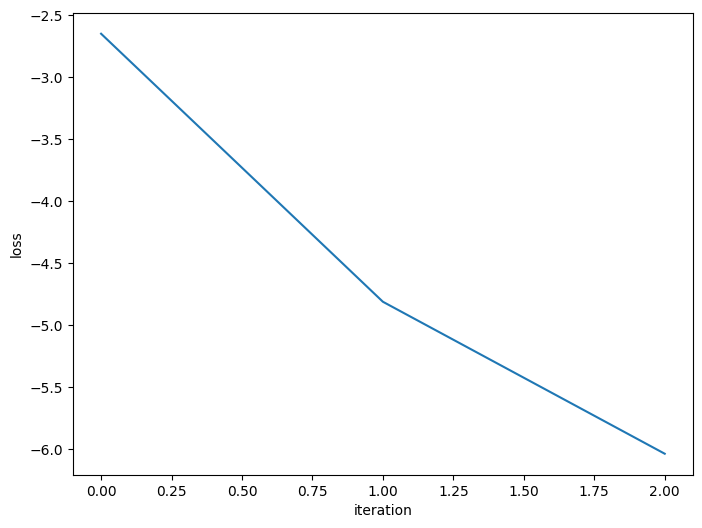

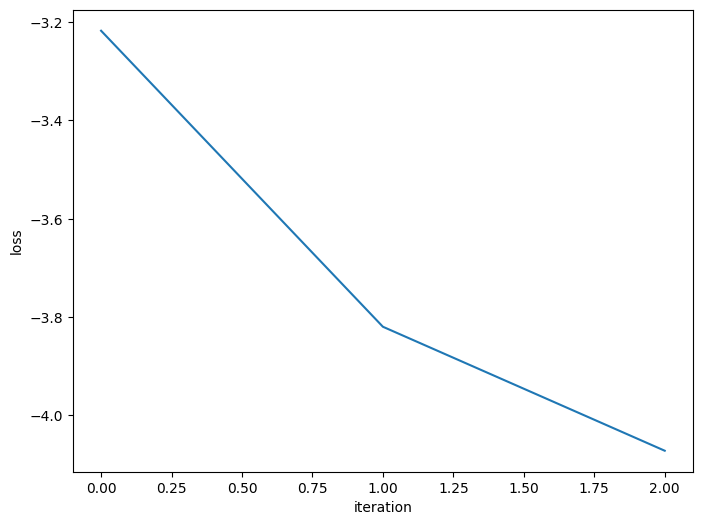

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -845.19142  validloss -648.17338±0.00000  bestvalidloss -648.17338  last_update 0
train: iter 1  trainloss -862.58005  validloss -706.88922±0.00000  bestvalidloss -706.88922  last_update 0
train: iter 2  trainloss -864.80353  validloss -778.65813±0.00000  bestvalidloss -778.65813  last_update 0
train: iter 3  trainloss -829.96497  validloss -599.72619±0.00000  bestvalidloss -778.65813  last_update 1
train: iter 4  trainloss -841.95181  validloss -691.94136±0.00000  bestvalidloss -778.65813  last_update 2
train: iter 5  trainloss -862.05786  validloss -759.22769±0.00000  bestvalidloss -778.65813  last_update 3
train: iter 6  trainloss -855.89856  validloss -750.64075±0.00000  bestvalidloss -778.65813  last_update 4
train: iter 7  trainloss -868.07032  validloss -751.33877±0.00000  bestvalidloss -778.65813  last_update 5
train: iter 8  trainloss -871.40845  validloss -759.98956±0.00000  bestvalidloss -778.65813  last_u

train: iter 76  trainloss -868.22901  validloss -783.61561±0.00000  bestvalidloss -799.59779  last_update 9
train: iter 77  trainloss -860.69409  validloss -770.12314±0.00000  bestvalidloss -799.59779  last_update 10
train: iter 78  trainloss -869.54241  validloss -777.86555±0.00000  bestvalidloss -799.59779  last_update 11
train: iter 79  trainloss -849.75107  validloss -685.39031±0.00000  bestvalidloss -799.59779  last_update 12
train: iter 80  trainloss -864.80295  validloss -736.44915±0.00000  bestvalidloss -799.59779  last_update 13
train: iter 81  trainloss -824.35867  validloss -719.45036±0.00000  bestvalidloss -799.59779  last_update 14
train: iter 82  trainloss -857.18817  validloss -726.60998±0.00000  bestvalidloss -799.59779  last_update 15
train: iter 83  trainloss -865.18490  validloss -739.34806±0.00000  bestvalidloss -799.59779  last_update 16
train: iter 84  trainloss -867.65997  validloss -743.27549±0.00000  bestvalidloss -799.59779  last_update 17
train: iter 85  trai

train: iter 151  trainloss -845.41769  validloss -759.44128±0.00000  bestvalidloss -799.59779  last_update 84
train: iter 152  trainloss -860.15764  validloss -635.88113±0.00000  bestvalidloss -799.59779  last_update 85
train: iter 153  trainloss -857.08197  validloss -776.12359±0.00000  bestvalidloss -799.59779  last_update 86
train: iter 154  trainloss -876.35271  validloss -726.92959±0.00000  bestvalidloss -799.59779  last_update 87
train: iter 155  trainloss -862.67702  validloss -770.65644±0.00000  bestvalidloss -799.59779  last_update 88
train: iter 156  trainloss -868.22374  validloss -788.37371±0.00000  bestvalidloss -799.59779  last_update 89
train: iter 157  trainloss -854.45043  validloss -659.07791±0.00000  bestvalidloss -799.59779  last_update 90
train: iter 158  trainloss -870.66995  validloss -779.53189±0.00000  bestvalidloss -799.59779  last_update 91
train: iter 159  trainloss -859.72220  validloss -765.94657±0.00000  bestvalidloss -799.59779  last_update 92
train: ite

train: iter 226  trainloss -863.88656  validloss -800.84653±0.00000  bestvalidloss -804.40503  last_update 12
train: iter 227  trainloss -803.05127  validloss -405.91829±0.00000  bestvalidloss -804.40503  last_update 13
train: iter 228  trainloss -877.42154  validloss -742.70125±0.00000  bestvalidloss -804.40503  last_update 14
train: iter 229  trainloss -863.33651  validloss -727.66213±0.00000  bestvalidloss -804.40503  last_update 15
train: iter 230  trainloss -874.65827  validloss -780.60870±0.00000  bestvalidloss -804.40503  last_update 16
train: iter 231  trainloss -858.08034  validloss -755.62241±0.00000  bestvalidloss -804.40503  last_update 17
train: iter 232  trainloss -871.81953  validloss -746.62949±0.00000  bestvalidloss -804.40503  last_update 18
train: iter 233  trainloss -868.39759  validloss -780.69871±0.00000  bestvalidloss -804.40503  last_update 19
train: iter 234  trainloss -853.51655  validloss -687.41047±0.00000  bestvalidloss -804.40503  last_update 20
train: ite

train: iter 301  trainloss -858.12359  validloss -761.24486±0.00000  bestvalidloss -822.60299  last_update 33
train: iter 302  trainloss -878.54232  validloss -749.82117±0.00000  bestvalidloss -822.60299  last_update 34
train: iter 303  trainloss -877.28603  validloss -771.13357±0.00000  bestvalidloss -822.60299  last_update 35
train: iter 304  trainloss -862.64733  validloss -682.89305±0.00000  bestvalidloss -822.60299  last_update 36
train: iter 305  trainloss -859.91978  validloss -764.57149±0.00000  bestvalidloss -822.60299  last_update 37
train: iter 306  trainloss -883.43479  validloss -792.25694±0.00000  bestvalidloss -822.60299  last_update 38
train: iter 307  trainloss -853.73396  validloss -747.28318±0.00000  bestvalidloss -822.60299  last_update 39
train: iter 308  trainloss -879.66022  validloss -752.27671±0.00000  bestvalidloss -822.60299  last_update 40
train: iter 309  trainloss -881.29677  validloss -787.48622±0.00000  bestvalidloss -822.60299  last_update 41
train: ite

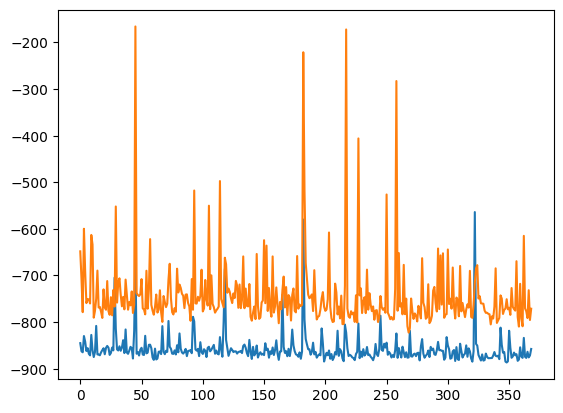

alpha 0.1 default_lr 0.0005


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [32]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [33]:
print(datetime.datetime.now())

2023-07-30 13:14:44.679239


# Iter 4

In [34]:
policy_evaluation_iter=3

In [35]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12
predict diverge [-17.05740478  -4.28478399 -36.45756848 -32.60080476] [  0.89541644 -22.03463702  -1.46651128  -4.25878051] [139.468     23.342175 153.2716    28.861576] [69.734    11.671087 76.6358   14.430788] sim_timestep 155

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39
predict diverge [-16.55718405  12.0419241  -38.93152204 -30.13560771] [ 0.43480527  4.16953508 -1.38269212 -3.03867285] [139.468     23.342175 153.2716    28.861576] [69.734    11.671087 76.6358   14.430788] sim_timestep 176

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50
predict diverge [ -2.91585923   4.91146521 -40.18049956 -29.35322472] [ 0.3786621  -2.31818316 -1.46243985 -2.072141  ] [139.468     23.342175 153.2716    28.861576] [69.734    11.671087 76.6358   14.430788] sim_timestep 174

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61
predict diverge [-20.

In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.46153  validloss 0.55558±0.00000  bestvalidloss 0.55558  last_update 0
train: iter 1  trainloss 0.42564  validloss 0.51498±0.00000  bestvalidloss 0.51498  last_update 0
train: iter 2  trainloss 0.41466  validloss 0.51529±0.00000  bestvalidloss 0.51498  last_update 1
train: iter 3  trainloss 0.40455  validloss 0.50892±0.00000  bestvalidloss 0.50892  last_update 0
train: iter 4  trainloss 0.39805  validloss 0.50727±0.00000  bestvalidloss 0.50727  last_update 0
train: iter 5  trainloss 0.39856  validloss 0.50150±0.00000  bestvalidloss 0.50150  last_update 0
train: iter 6  trainloss 0.39053  validloss 0.52552±0.00000  bestvalidloss 0.50150  last_update 1
train: iter 7  trainloss 0.38725  validloss 0.48437±0.00000  bestvalidloss 0.48437  last_update 0
train: iter 8  trainloss 0.38294  validloss 0.49145±0.00000  bestvalidloss 0.48437  last_update 1
train: iter 9  trainloss 0.38282  validloss 0.48584±0.00000  bestvalidloss 0.48437  last_update 2
train: iter 10  trai

train: iter 83  trainloss 0.34844  validloss 0.44799±0.00000  bestvalidloss 0.42991  last_update 48
train: iter 84  trainloss 0.34916  validloss 0.46976±0.00000  bestvalidloss 0.42991  last_update 49
train: iter 85  trainloss 0.35045  validloss 0.45600±0.00000  bestvalidloss 0.42991  last_update 50
train: iter 86  trainloss 0.34745  validloss 0.45972±0.00000  bestvalidloss 0.42991  last_update 51
train: iter 87  trainloss 0.34938  validloss 0.44442±0.00000  bestvalidloss 0.42991  last_update 52
train: iter 88  trainloss 0.34913  validloss 0.43912±0.00000  bestvalidloss 0.42991  last_update 53
train: iter 89  trainloss 0.35083  validloss 0.43815±0.00000  bestvalidloss 0.42991  last_update 54
train: iter 90  trainloss 0.34903  validloss 0.43210±0.00000  bestvalidloss 0.42991  last_update 55
train: iter 91  trainloss 0.34553  validloss 0.47380±0.00000  bestvalidloss 0.42991  last_update 56
train: iter 92  trainloss 0.34544  validloss 0.43757±0.00000  bestvalidloss 0.42991  last_update 57


train_loss:  -6.975481334444882
valid_loss:  -7.518430745589734
weight_alpha 1.0 h_min_tilde -12.184162 ell_tilde -7.084071216673852 kappa_tilde 0.0004428034956191028
train_loss:  -4.655569941663741
valid_loss:  -4.200709145224095
weight_alpha 0.1 h_min_tilde -12.184162 ell_tilde -4.564597782375812 kappa_tilde 0.0003622721338664483


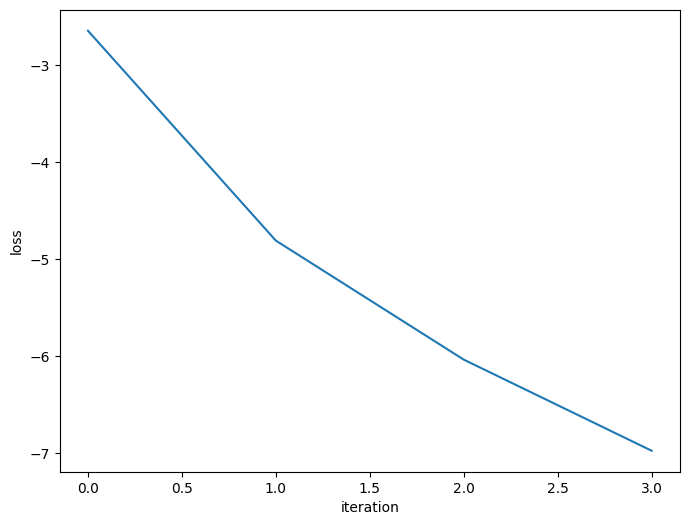

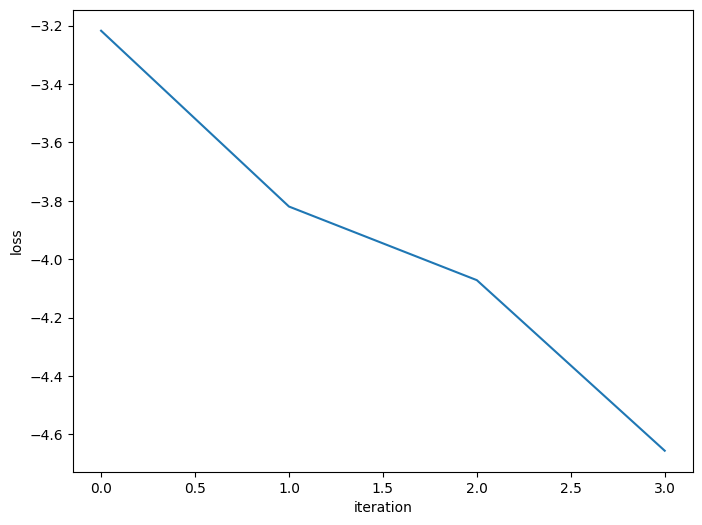

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -935.57255  validloss -843.05551±0.00000  bestvalidloss -843.05551  last_update 0
train: iter 1  trainloss -950.60428  validloss -779.64003±0.00000  bestvalidloss -843.05551  last_update 1
train: iter 2  trainloss -916.12162  validloss -842.30928±0.00000  bestvalidloss -843.05551  last_update 2
train: iter 3  trainloss -948.28981  validloss -855.44625±0.00000  bestvalidloss -855.44625  last_update 0
train: iter 4  trainloss -951.58611  validloss -874.91554±0.00000  bestvalidloss -874.91554  last_update 0
train: iter 5  trainloss -952.37638  validloss -864.65601±0.00000  bestvalidloss -874.91554  last_update 1
train: iter 6  trainloss -935.71638  validloss -809.69501±0.00000  bestvalidloss -874.91554  last_update 2
train: iter 7  trainloss -953.30571  validloss -868.70581±0.00000  bestvalidloss -874.91554  last_update 3
train: iter 8  trainloss -939.57757  validloss -853.05800±0.00000  bestvalidloss -874.91554  last_u

train: iter 76  trainloss -951.19767  validloss -846.87475±0.00000  bestvalidloss -899.68989  last_update 61
train: iter 77  trainloss -949.26840  validloss -822.44899±0.00000  bestvalidloss -899.68989  last_update 62
train: iter 78  trainloss -956.56312  validloss -870.13283±0.00000  bestvalidloss -899.68989  last_update 63
train: iter 79  trainloss -934.60411  validloss -814.36756±0.00000  bestvalidloss -899.68989  last_update 64
train: iter 80  trainloss -948.31429  validloss -867.72422±0.00000  bestvalidloss -899.68989  last_update 65
train: iter 81  trainloss -957.48997  validloss -836.37289±0.00000  bestvalidloss -899.68989  last_update 66
train: iter 82  trainloss -849.95243  validloss -712.37614±0.00000  bestvalidloss -899.68989  last_update 67
train: iter 83  trainloss -941.12542  validloss -818.46669±0.00000  bestvalidloss -899.68989  last_update 68
train: iter 84  trainloss -950.47281  validloss -818.26386±0.00000  bestvalidloss -899.68989  last_update 69
train: iter 85  tra

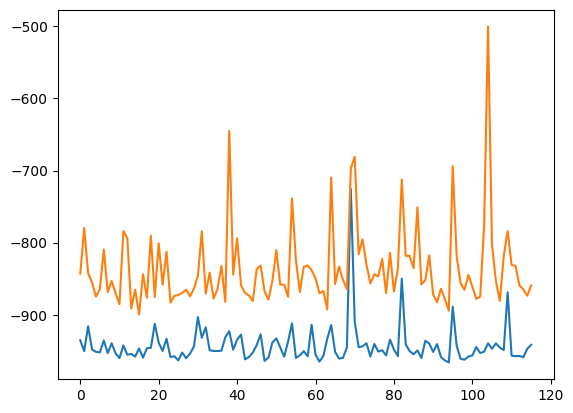

alpha 0.1 default_lr 0.0005


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [40]:
print(datetime.datetime.now())

2023-07-30 13:39:06.881911


# Iter 5

In [41]:
policy_evaluation_iter=4

In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8
predict diverge [-15.66012531  -7.51600778 -33.95147508 -31.41465583] [ 0.07836749 -7.7838099  -1.33735028 -2.87001494] [139.468     23.342175 153.2716    28.861576] [69.734    11.671087 76.6358   14.430788] sim_timestep 185

 9

 10

 11

 12

 13

 14

 15

 16

 17
predict diverge [-28.92846798  26.75354708 -30.62122613 -25.79072172] [ 0.71757728 11.68394711 -1.35541417  0.64359384] [139.468     23.342175 153.2716    28.861576] [69.734    11.671087 76.6358   14.430788] sim_timestep 147

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.38708  validloss 0.59173±0.00000  bestvalidloss 0.59173  last_update 0
train: iter 1  trainloss 0.37176  validloss 0.55060±0.00000  bestvalidloss 0.55060  last_update 0
train: iter 2  trainloss 0.36637  validloss 0.54670±0.00000  bestvalidloss 0.54670  last_update 0
train: iter 3  trainloss 0.36446  validloss 0.54585±0.00000  bestvalidloss 0.54585  last_update 0
train: iter 4  trainloss 0.35869  validloss 0.55332±0.00000  bestvalidloss 0.54585  last_update 1
train: iter 5  trainloss 0.36049  validloss 0.52364±0.00000  bestvalidloss 0.52364  last_update 0
train: iter 6  trainloss 0.35613  validloss 0.54194±0.00000  bestvalidloss 0.52364  last_update 1
train: iter 7  trainloss 0.36303  validloss 0.54046±0.00000  bestvalidloss 0.52364  last_update 2
train: iter 8  trainloss 0.35625  validloss 0.57961±0.00000  bestvalidloss 0.52364  last_update 3
train: iter 9  trainloss 0.35775  validloss 0.53630±0.00000  bestvalidloss 0.52364  last_update 4
train: iter 10  trai

train: iter 83  trainloss 0.33113  validloss 0.68098±0.00000  bestvalidloss 0.52364  last_update 78
train: iter 84  trainloss 0.32950  validloss 0.65982±0.00000  bestvalidloss 0.52364  last_update 79
train: iter 85  trainloss 0.32763  validloss 0.63444±0.00000  bestvalidloss 0.52364  last_update 80
train: iter 86  trainloss 0.33101  validloss 0.68287±0.00000  bestvalidloss 0.52364  last_update 81
train: iter 87  trainloss 0.33140  validloss 0.63785±0.00000  bestvalidloss 0.52364  last_update 82
train: iter 88  trainloss 0.33164  validloss 0.64671±0.00000  bestvalidloss 0.52364  last_update 83
train: iter 89  trainloss 0.32734  validloss 0.63909±0.00000  bestvalidloss 0.52364  last_update 84
train: iter 90  trainloss 0.32710  validloss 0.63404±0.00000  bestvalidloss 0.52364  last_update 85
train: iter 91  trainloss 0.33004  validloss 0.66225±0.00000  bestvalidloss 0.52364  last_update 86
train: iter 92  trainloss 0.32439  validloss 0.65136±0.00000  bestvalidloss 0.52364  last_update 87


train_loss:  -5.750366713407635
valid_loss:  -5.039611626017093
weight_alpha 1.0 h_min_tilde -12.168621 ell_tilde -5.608215695929527 kappa_tilde 0.00039042234206854837
train_loss:  -4.219112942409516
valid_loss:  -3.8064492111206056
weight_alpha 0.1 h_min_tilde -12.168621 ell_tilde -4.1365801961517334 kappa_tilde 0.00035284750043731


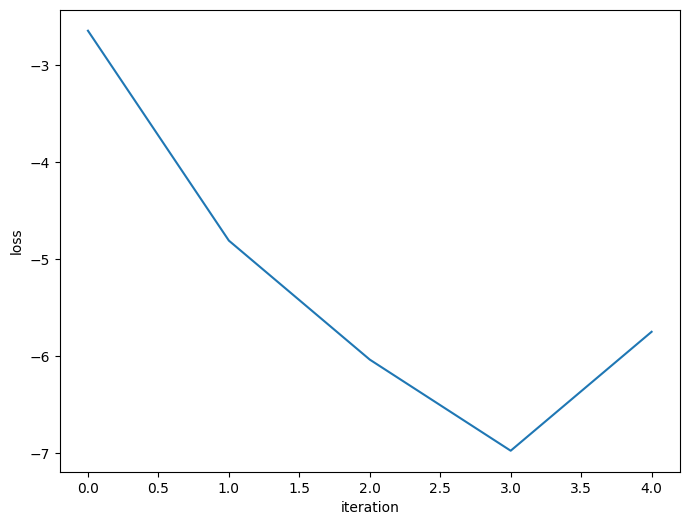

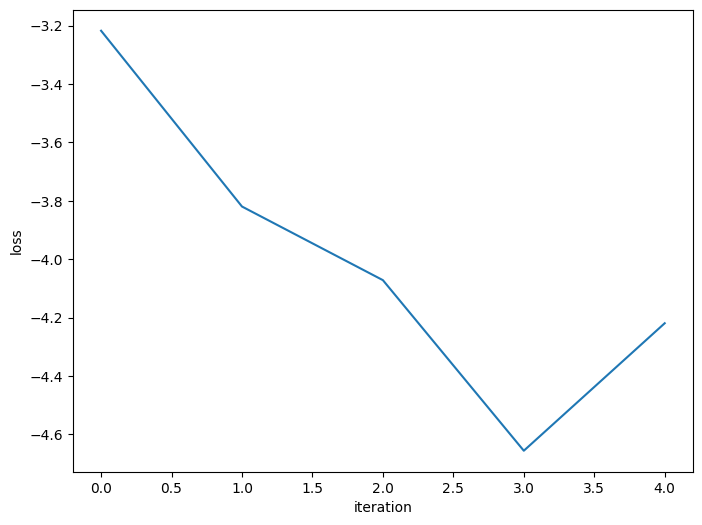

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -830.81476  validloss -763.03543±0.00000  bestvalidloss -763.03543  last_update 0
train: iter 1  trainloss -835.23878  validloss -645.80312±0.00000  bestvalidloss -763.03543  last_update 1
train: iter 2  trainloss -843.17919  validloss -757.08841±0.00000  bestvalidloss -763.03543  last_update 2
train: iter 3  trainloss -850.06978  validloss -767.96637±0.00000  bestvalidloss -767.96637  last_update 0
train: iter 4  trainloss -819.85345  validloss -659.75734±0.00000  bestvalidloss -767.96637  last_update 1
train: iter 5  trainloss -845.30638  validloss -718.85318±0.00000  bestvalidloss -767.96637  last_update 2
train: iter 6  trainloss -848.11000  validloss -758.80435±0.00000  bestvalidloss -767.96637  last_update 3
train: iter 7  trainloss -809.40701  validloss -629.56328±0.00000  bestvalidloss -767.96637  last_update 4
train: iter 8  trainloss -837.42494  validloss -473.29498±0.00000  bestvalidloss -767.96637  last_u

train: iter 76  trainloss -851.30588  validloss -743.50763±0.00000  bestvalidloss -772.45117  last_update 60
train: iter 77  trainloss -841.96467  validloss -743.20946±0.00000  bestvalidloss -772.45117  last_update 61
train: iter 78  trainloss -834.47287  validloss -673.94779±0.00000  bestvalidloss -772.45117  last_update 62
train: iter 79  trainloss -844.40798  validloss -726.93849±0.00000  bestvalidloss -772.45117  last_update 63
train: iter 80  trainloss -847.76732  validloss -773.21312±0.00000  bestvalidloss -773.21312  last_update 0
train: iter 81  trainloss -793.92543  validloss -682.30515±0.00000  bestvalidloss -773.21312  last_update 1
train: iter 82  trainloss -799.09981  validloss -524.64463±0.00000  bestvalidloss -773.21312  last_update 2
train: iter 83  trainloss -841.38574  validloss -744.89893±0.00000  bestvalidloss -773.21312  last_update 3
train: iter 84  trainloss -837.36537  validloss -744.46987±0.00000  bestvalidloss -773.21312  last_update 4
train: iter 85  trainlos

train: iter 151  trainloss -855.73412  validloss -754.86945±0.00000  bestvalidloss -773.21312  last_update 71
train: iter 152  trainloss -837.35875  validloss -764.88352±0.00000  bestvalidloss -773.21312  last_update 72
train: iter 153  trainloss -846.82409  validloss -735.24989±0.00000  bestvalidloss -773.21312  last_update 73
train: iter 154  trainloss -816.83755  validloss -727.53828±0.00000  bestvalidloss -773.21312  last_update 74
train: iter 155  trainloss -836.99816  validloss -652.53937±0.00000  bestvalidloss -773.21312  last_update 75
train: iter 156  trainloss -852.59611  validloss -738.22065±0.00000  bestvalidloss -773.21312  last_update 76
train: iter 157  trainloss -840.34940  validloss -711.47510±0.00000  bestvalidloss -773.21312  last_update 77
train: iter 158  trainloss -854.09637  validloss -763.74693±0.00000  bestvalidloss -773.21312  last_update 78
train: iter 159  trainloss -847.62750  validloss -769.18248±0.00000  bestvalidloss -773.21312  last_update 79
train: ite

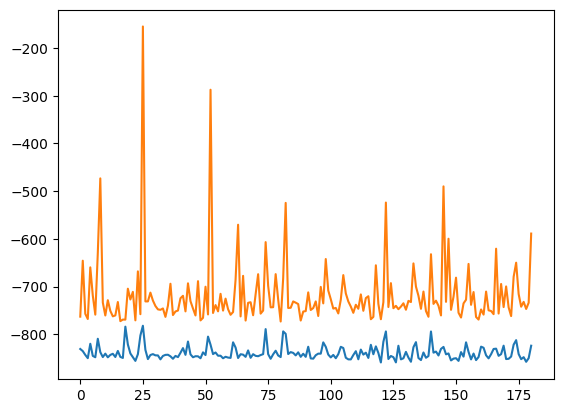

alpha 0.1 default_lr 0.0005


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [47]:
print(datetime.datetime.now())

2023-07-30 14:02:46.588710


# 評価関数計算

In [48]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57
predict diverge [ -4.03205405 -15.93953916  53.83907072  29.49647794] [-0.7737133  -0.79767597  1.29771478  1.53645873] [139.468     23.342175 153.2716    28.861576] [69.734    11.671087 76.6358   14.430788] sim_timestep 91

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [49]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.39917  validloss 0.62456±0.00000  bestvalidloss 0.62456  last_update 0
train: iter 1  trainloss 0.38496  validloss 0.53812±0.00000  bestvalidloss 0.53812  last_update 0
train: iter 2  trainloss 0.38072  validloss 0.52006±0.00000  bestvalidloss 0.52006  last_update 0
train: iter 3  trainloss 0.37964  validloss 0.50448±0.00000  bestvalidloss 0.50448  last_update 0
train: iter 4  trainloss 0.37975  validloss 0.51297±0.00000  bestvalidloss 0.50448  last_update 1
train: iter 5  trainloss 0.37529  validloss 0.51066±0.00000  bestvalidloss 0.50448  last_update 2
train: iter 6  trainloss 0.37573  validloss 0.52107±0.00000  bestvalidloss 0.50448  last_update 3
train: iter 7  trainloss 0.37016  validloss 0.53883±0.00000  bestvalidloss 0.50448  last_update 4
train: iter 8  trainloss 0.37105  validloss 0.51787±0.00000  bestvalidloss 0.50448  last_update 5
train: iter 9  trainloss 0.36878  validloss 0.52468±0.00000  bestvalidloss 0.50448  last_update 6
train: iter 10  trai

train: iter 83  trainloss 0.33563  validloss 0.60465±0.00000  bestvalidloss 0.50448  last_update 80
train: iter 84  trainloss 0.33608  validloss 0.58376±0.00000  bestvalidloss 0.50448  last_update 81
train: iter 85  trainloss 0.33473  validloss 0.58960±0.00000  bestvalidloss 0.50448  last_update 82
train: iter 86  trainloss 0.33637  validloss 0.60575±0.00000  bestvalidloss 0.50448  last_update 83
train: iter 87  trainloss 0.33598  validloss 0.60262±0.00000  bestvalidloss 0.50448  last_update 84
train: iter 88  trainloss 0.33590  validloss 0.59844±0.00000  bestvalidloss 0.50448  last_update 85
train: iter 89  trainloss 0.33891  validloss 0.60895±0.00000  bestvalidloss 0.50448  last_update 86
train: iter 90  trainloss 0.34161  validloss 0.62079±0.00000  bestvalidloss 0.50448  last_update 87
train: iter 91  trainloss 0.33895  validloss 0.58344±0.00000  bestvalidloss 0.50448  last_update 88
train: iter 92  trainloss 0.33710  validloss 0.60598±0.00000  bestvalidloss 0.50448  last_update 89


([0.3991657257080078,
  0.3849647695198655,
  0.3807201338931918,
  0.3796447799541056,
  0.3797455998137593,
  0.37529482832178473,
  0.3757335521280766,
  0.37015685848891733,
  0.3710530868731439,
  0.36877666134387255,
  0.3646204062737525,
  0.3650635845027864,
  0.3654112223535776,
  0.36702771643176674,
  0.3638487717136741,
  0.3627600396052003,
  0.36455030646175146,
  0.36047990517690776,
  0.36216107187792657,
  0.36222920212894677,
  0.3598769728094339,
  0.3575073559768498,
  0.35945128463208675,
  0.3588602552190423,
  0.35836483296006916,
  0.35509042548947034,
  0.3575806929729879,
  0.35594373354688286,
  0.36039811512455344,
  0.3518227692693472,
  0.35265521742403505,
  0.3527461259625852,
  0.3560610883869231,
  0.35438442244194446,
  0.3545055462047458,
  0.3512547655031085,
  0.3533411564305425,
  0.3505548068322241,
  0.3525582400150597,
  0.3492877692915499,
  0.34998388569802047,
  0.3479043813422322,
  0.3451448928564787,
  0.34787788782268764,
  0.34702011207

In [50]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -5.706272300434113
valid_loss:  -5.239021598219872
weight_alpha 1.0 h_min_tilde -12.241903 ell_tilde -5.612822159991265 kappa_tilde 0.0003883947335307668
train_loss:  -4.229328905963898
valid_loss:  -3.6691766693115233
weight_alpha 0.1 h_min_tilde -12.241903 ell_tilde -4.117298458633423 kappa_tilde 0.0003508317390522382


In [51]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 4.49245  validloss 4.80436±0.00000  bestvalidloss 4.80436  last_update 0
train: iter 1  trainloss 3.12641  validloss 3.19279±0.00000  bestvalidloss 3.19279  last_update 0
train: iter 2  trainloss 2.08680  validloss 2.05703±0.00000  bestvalidloss 2.05703  last_update 0
train: iter 3  trainloss 1.46650  validloss 1.34732±0.00000  bestvalidloss 1.34732  last_update 0
train: iter 4  trainloss 0.96082  validloss 0.76651±0.00000  bestvalidloss 0.76651  last_update 0
train: iter 5  trainloss 0.65179  validloss 0.29491±0.00000  bestvalidloss 0.29491  last_update 0
train: iter 6  trainloss 0.40624  validloss 0.13208±0.00000  bestvalidloss 0.13208  last_update 0
train: iter 7  trainloss 0.27900  validloss -0.05454±0.00000  bestvalidloss -0.05454  last_update 0
train: iter 8  trainloss 0.18954  validloss -0.18051±0.00000  bestvalidloss -0.18051  last_update 0
train: iter 9  trainloss 0.10659  validloss -0.22711±0.00000  bestvalidloss -0.22711  last_update 0
train: iter 10

train: iter 88  trainloss -0.10866  validloss -0.40876±0.00000  bestvalidloss -0.48444  last_update 42
train: iter 89  trainloss -0.10761  validloss -0.45274±0.00000  bestvalidloss -0.48444  last_update 43
train: iter 90  trainloss -0.11101  validloss -0.40233±0.00000  bestvalidloss -0.48444  last_update 44
train: iter 91  trainloss -0.09261  validloss -0.39914±0.00000  bestvalidloss -0.48444  last_update 45
train: iter 92  trainloss -0.08828  validloss -0.42063±0.00000  bestvalidloss -0.48444  last_update 46
train: iter 93  trainloss -0.08951  validloss -0.41962±0.00000  bestvalidloss -0.48444  last_update 47
train: iter 94  trainloss -0.08096  validloss -0.43582±0.00000  bestvalidloss -0.48444  last_update 48
train: iter 95  trainloss -0.10922  validloss -0.43945±0.00000  bestvalidloss -0.48444  last_update 49
train: iter 96  trainloss -0.08243  validloss -0.40636±0.00000  bestvalidloss -0.48444  last_update 50
train: iter 97  trainloss -0.11561  validloss -0.43030±0.00000  bestvalid

In [52]:
print(iwvi.initial_belief)


Parameter containing:
tensor([ 0.7264, -1.3984, -2.4789, -3.4269], requires_grad=True)


In [53]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 6.03810  validloss 12.93939±0.00000  bestvalidloss 12.93939  last_update 0
train: iter 1  trainloss 5.88226  validloss 13.45969±0.00000  bestvalidloss 12.93939  last_update 1
train: iter 2  trainloss 5.85759  validloss 12.62027±0.00000  bestvalidloss 12.62027  last_update 0
train: iter 3  trainloss 5.85049  validloss 13.13757±0.00000  bestvalidloss 12.62027  last_update 1
train: iter 4  trainloss 5.91279  validloss 13.59289±0.00000  bestvalidloss 12.62027  last_update 2
train: iter 5  trainloss 5.77764  validloss 13.61676±0.00000  bestvalidloss 12.62027  last_update 3
train: iter 6  trainloss 5.85834  validloss 13.30472±0.00000  bestvalidloss 12.62027  last_update 4
train: iter 7  trainloss 5.74855  validloss 13.19123±0.00000  bestvalidloss 12.62027  last_update 5
train: iter 8  trainloss 5.78782  validloss 13.07199±0.00000  bestvalidloss 12.62027  last_update 6
train: iter 9  trainloss 5.77199  validloss 13.20652±0.00000  bestvalidloss 12.62027  last_update 7


train: iter 81  trainloss 5.44557  validloss 13.15355±0.00000  bestvalidloss 12.22228  last_update 70
train: iter 82  trainloss 5.47927  validloss 13.48757±0.00000  bestvalidloss 12.22228  last_update 71
train: iter 83  trainloss 5.48824  validloss 13.74732±0.00000  bestvalidloss 12.22228  last_update 72
train: iter 84  trainloss 5.40265  validloss 13.96194±0.00000  bestvalidloss 12.22228  last_update 73
train: iter 85  trainloss 5.49219  validloss 12.82223±0.00000  bestvalidloss 12.22228  last_update 74
train: iter 86  trainloss 5.45274  validloss 13.94991±0.00000  bestvalidloss 12.22228  last_update 75
train: iter 87  trainloss 5.49966  validloss 14.64677±0.00000  bestvalidloss 12.22228  last_update 76
train: iter 88  trainloss 5.42279  validloss 14.00886±0.00000  bestvalidloss 12.22228  last_update 77
train: iter 89  trainloss 5.39896  validloss 13.48634±0.00000  bestvalidloss 12.22228  last_update 78
train: iter 90  trainloss 5.44003  validloss 13.14267±0.00000  bestvalidloss 12.22

In [54]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-6.5777)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(3.6437)


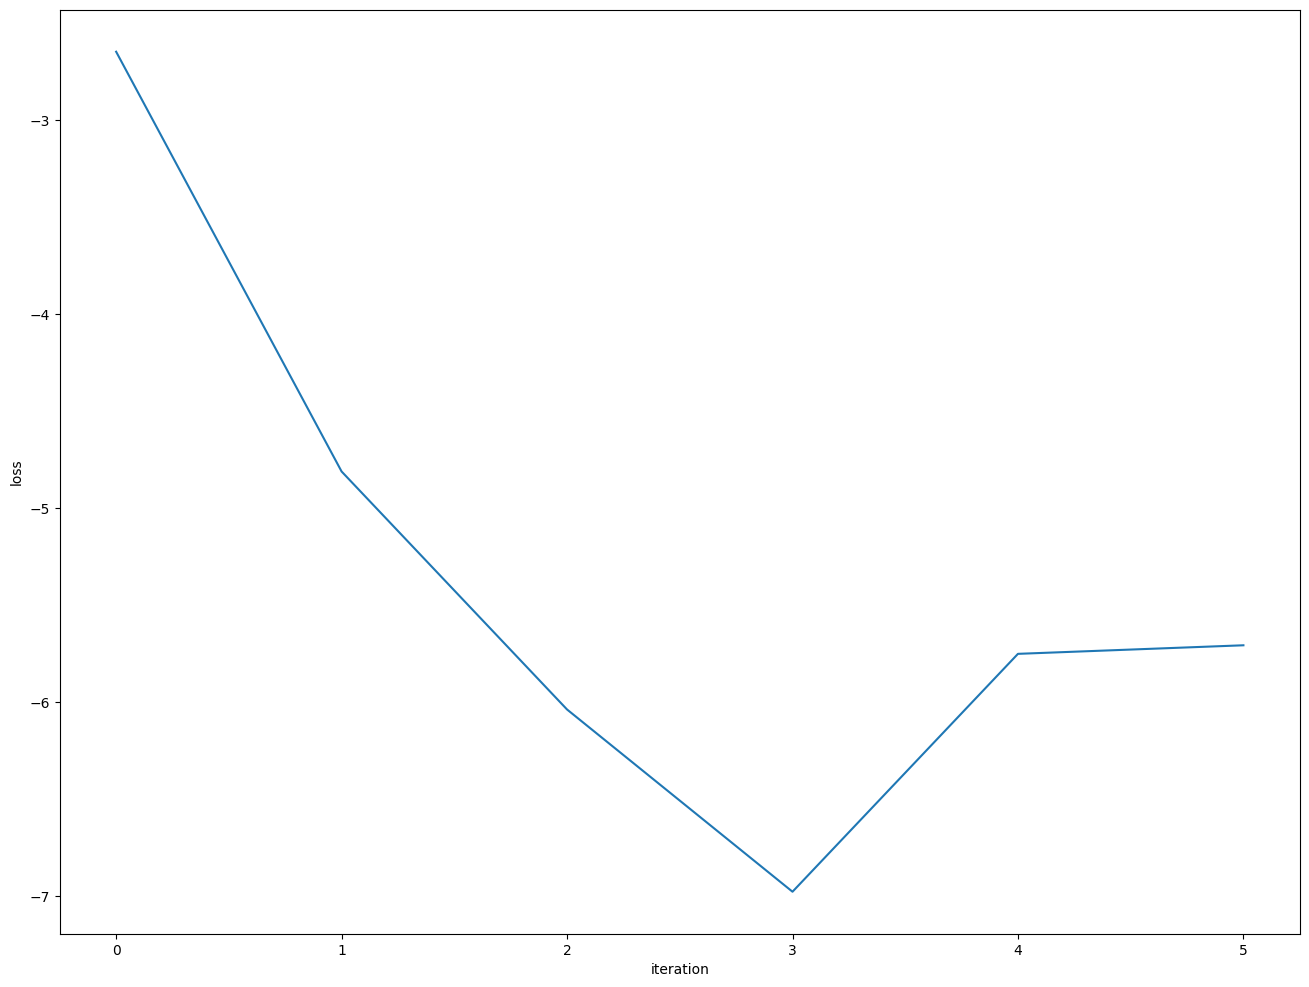

In [55]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

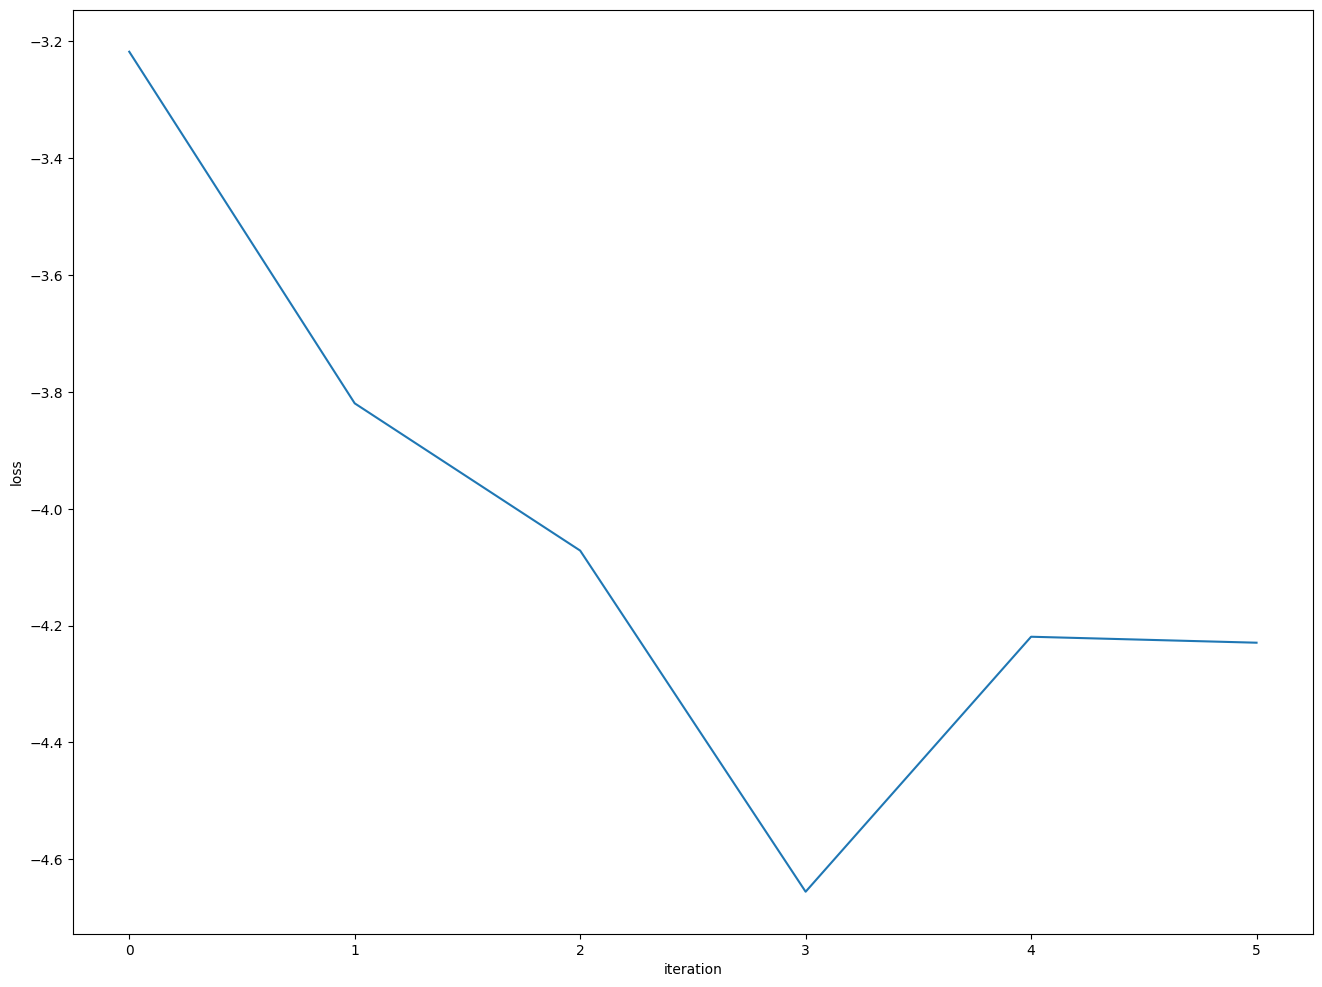

In [56]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")